# Vaccines and patient characteristics

### Import libraries and data

The datasets used for this report are created using the study definition [`/analysis/study_definition.py`](../analysis/study_definition.py), using codelists referenced in [`/codelists/codelists.txt`](../codelists/codelists.txt). 

In [1]:
%load_ext autoreload
%autoreload 2
 
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import subprocess
from IPython.display import display, Markdown, HTML
import os


suffix = "_tpp"

# get current branch
current_branch = subprocess.run(["git", "rev-parse", "--abbrev-ref", "HEAD"], capture_output=True).stdout.decode("utf8").strip()


### Import our custom functions

In [2]:
# import custom functions from 'lib' folder
import sys
sys.path.append('../lib/')


In [3]:
from data_processing import load_data
from second_third_doses import abbreviate_time_period

In [4]:
from report_results import find_and_save_latest_date, create_output_dirs

In [5]:
# create output directories to save files into 
savepath, savepath_figure_csvs, savepath_table_csvs = create_output_dirs()

### Load and Process the raw data 

In [6]:
df = load_data()

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/data_processing.py:152: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(["imd","ethnicity_16", "ethnicity", 'ethnicity_6_sus',
/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/data_processing.py:195: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(['care_home', 'age'], 1)


In [7]:
latest_date, formatted_latest_date = find_and_save_latest_date(df, savepath=savepath)

In [8]:
print(f"Latest Date: {formatted_latest_date}")

Latest Date: 15 Dec 2021


### Summarise by group and demographics at latest date

#### Calculate cumulative sums at each date and select latest date + previous figures for comparison

In [9]:
from report_results import cumulative_sums

In [10]:
# population subgroups - in a dict to indicate which field to filter on


population_subgroups = {"80+":1,
        "70-79":2, 
        "care home":3, 
        "shielding (aged 16-69)":4, 
        "65-69": 5,  
        "LD (aged 16-64)": 6,  
        "60-64": 7,
        "55-59": 8,
        "50-54": 9,
        "40-49": 10,
        "30-39": 11,
        "18-29": 12,                
        "16-17": 0 
        # NB if the population denominator is not included for the final group (0), the key must contain phrase "not in other eligible groups" so that data is presented appropriately
        }

groups = population_subgroups.keys()


#  list demographic/clinical factors to include for given group
DEFAULT = ["sex","ageband_5yr","ethnicity_6_groups","ethnicity_16_groups", "imd_categories", 
                              "bmi", "housebound", "chronic_cardiac_disease", "current_copd", "dmards", "dementia",
                              "psychosis_schiz_bipolar","LD","ssri",
                              "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer", "ckd"]
#for specific age bands remove features which are included elsehwere or not prevalent
o65 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis")]
o60 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis", "LD", "housebound")]
o50 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis", "LD", "dementia",
                                       "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer", "housebound"
                                      )]
o40 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis", "LD", "dementia",
                                       "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer", "housebound"
                                       )]
# under50s
u40 = ["sex", "ethnicity_6_groups", "ethnicity_16_groups","imd_categories"]

# dictionary mapping population subgroups to a list of demographic/clinical factors to include for that group
features_dict = {0:    u40, ## patients not assigned to a priority group
                 "care home": ["sex", "ageband_5yr", "ethnicity_6_groups", "dementia"],
                 "shielding (aged 16-69)": ["newly_shielded_since_feb_15", "sex", "ageband", "ethnicity_6_groups", "imd_categories",
                                           "LD", "ckd"],
                 "65-69":    o65,
                 "60-64":    o60,
                 "55-59":    o50,
                 "50-54":    o50,
                 "40-49":    o40,
                 "30-39":    u40,
                 "18-29":    u40,
                 "16-17":    ["sex", "ethnicity_6_groups", "imd_categories"],
                 "LD (aged 16-64)":  ["sex", "ageband_5yr", "ethnicity_6_groups"],
                 "DEFAULT":   DEFAULT # other age groups
                }


In [11]:
df_dict_cum = cumulative_sums(df, groups_of_interest=population_subgroups, features_dict=features_dict, latest_date=latest_date)

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:192: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out2 = out2.rename(columns={0:"overall"}).drop(["level_0"],1)


In [12]:
# for details on second/third doses, no need for breakdowns of any groups (only "overall" figures will be included)
second_dose_features = {}
for g in groups:
    second_dose_features[g] = []

df_dict_cum_second_dose = cumulative_sums(df, groups_of_interest=population_subgroups, features_dict=second_dose_features, 
                                          latest_date=latest_date, reference_column_name="covid_vacc_second_dose_date")

df_dict_cum_third_dose = cumulative_sums(df, groups_of_interest=population_subgroups, features_dict=second_dose_features, 
                                          latest_date=latest_date, reference_column_name="covid_vacc_third_dose_date")

### Cumulative vaccination figures - overall

In [13]:
from report_results import make_vaccine_graphs

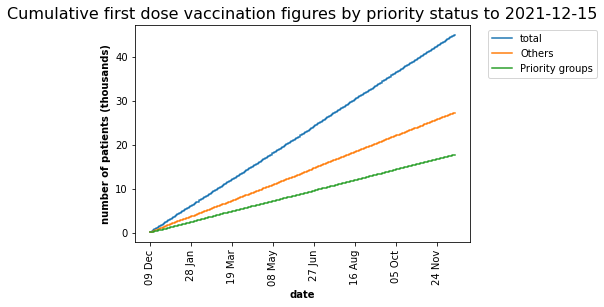

In [14]:
make_vaccine_graphs(df, latest_date=latest_date, grouping="priority_status", savepath_figure_csvs=savepath_figure_csvs, savepath=savepath, suffix=suffix)

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:311: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  dfp = dfp.drop("total", 1)


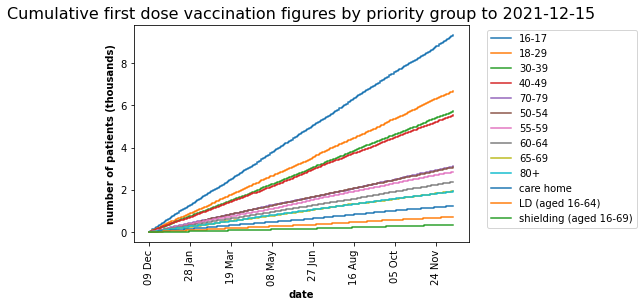

In [15]:
make_vaccine_graphs(df, latest_date=latest_date, include_total=False, savepath=savepath, savepath_figure_csvs=savepath_figure_csvs, suffix=suffix)

### Reports 

In [16]:
from report_results import summarise_data_by_group

In [17]:
summarised_data_dict = summarise_data_by_group(df_dict_cum, latest_date=latest_date, groups=groups)

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:412: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.transpose().append(date_reached).transpose().drop("weeks_to_target",1)
/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:422: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out2 = out2.loc[out2[reference_column_name]==latest_date].reset_index().set_index(reference_column_name).drop(["index"], 1).transpose()
/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:440: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' wi

In [18]:
summarised_data_dict_2nd_dose = summarise_data_by_group(df_dict_cum_second_dose, latest_date=latest_date, groups=groups)

summarised_data_dict_3rd_dose = summarise_data_by_group(df_dict_cum_third_dose, latest_date=latest_date, groups=groups)

### Proportion of each eligible population vaccinated to date

In [20]:
from report_results import create_summary_stats, create_detailed_summary_uptake

In [21]:
summ_stat_results, additional_stats = create_summary_stats(df, summarised_data_dict, formatted_latest_date, groups=groups, 
                                         savepath=savepath, suffix=suffix)

In [22]:
summ_stat_results_2nd_dose, _ = create_summary_stats(df, summarised_data_dict_2nd_dose, formatted_latest_date, 
                                                  groups=groups, savepath=savepath, 
                                                  vaccine_type="second_dose", suffix=suffix)

summ_stat_results_3rd_dose, _ = create_summary_stats(df, summarised_data_dict_3rd_dose, formatted_latest_date, 
                                                  groups=groups, savepath=savepath, 
                                                  vaccine_type="third_dose", suffix=suffix)

In [23]:
# display the results of the summary stats on first and second doses
display(pd.DataFrame(summ_stat_results).join(pd.DataFrame(summ_stat_results_2nd_dose)).join(pd.DataFrame(summ_stat_results_3rd_dose)))   
display(Markdown(f"*\n figures rounded to nearest 7"))

,first dose as at 15 Dec 2021,second dose as at 15 Dec 2021,third dose as at 15 Dec 2021
Total vaccinated in TPP,"45,003","39,998","4,998"
80+,"90.5% (1,939 of 2,142)","80.7% (1,729 of 2,142)","10.5% (224 of 2,142)"
70-79,"90.1% (3,136 of 3,479)","80.3% (2,793 of 3,479)","10.1% (350 of 3,479)"
care home,"89.9% (1,253 of 1,393)","79.9% (1,113 of 1,393)","8.5% (119 of 1,393)"
shielding (aged 16-69),88.3% (371 of 420),81.7% (343 of 420),11.7% (49 of 420)
65-69,"89.7% (1,946 of 2,170)","80.3% (1,743 of 2,170)","10.6% (231 of 2,170)"
LD (aged 16-64),90.4% (728 of 805),79.1% (637 of 805),10.4% (84 of 805)
60-64,"89.8% (2,401 of 2,674)","79.6% (2,128 of 2,674)","10.5% (280 of 2,674)"
55-59,"89.9% (2,863 of 3,185)","80.2% (2,555 of 3,185)","10.1% (322 of 3,185)"
50-54,"89.1% (3,080 of 3,458)","78.9% (2,730 of 3,458)","9.7% (336 of 3,458)"


*
 figures rounded to nearest 7

In [24]:
# other information on vaccines

for x in additional_stats.keys():
    display(Markdown(f"{x}: {additional_stats[x]}"))
    
display(Markdown(f"*\n figures rounded to nearest 7"))

Oxford-AZ vaccines (% of all first doses): **0.1%** (42)

Pfizer vaccines (% of all first doses): **0.2%** (84)

Moderna vaccines (% of all first doses): **0.1%** (28)

Second doses (% of all vaccinated): **88.9%** (39,998)

Second doses (% of Ox-AZ first doses): **6200.0%** (2,604)

Second doses (% of Pfizer first doses): **1500.0%** (1,260)

Second doses (% of Moderna first doses): **10875.0%** (3,045)

Mixed doses Ox-AZ + Pfizer (% of fully vaccinated): **0.0%** (0)

Mixed doses Ox-AZ + Moderna (% of fully vaccinated): **0.0%** (0)

Mixed doses Moderna + Pfizer (% of fully vaccinated): **0.0%** (0)

*
 figures rounded to nearest 7

# Detailed summary of coverage among population groups as at latest date

In [25]:
create_detailed_summary_uptake(summarised_data_dict, formatted_latest_date, 
                               groups=population_subgroups.keys(),
                               savepath=savepath)

## 

## COVID vaccination rollout (first dose) among **80+** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1939   
sex                       F                                          1029   
                          M                                           910   
ageband_5yr               0                                            21   
                          0-15                                        105   
                          16-17                                       126   
                          18-29                                       119   
                          30-34                                       126   
                          35-39                                       133   
                          40-44                                       133   
                          45-49                                       126   
                          50-54                                       133   
                          55-59                                       140   
                          60-64                                       119   
                          65-69                                       126   
                          70-74                                       126   
                          75-79                                       105   
                          80-84                                       140   
                          85-89                                       140   
                          90+                                          14   
ethnicity_6_groups        Black                                       322   
                          Mixed                                       315   
                          Other                                       308   
                          South Asian                                 329   
                          Unknown                                     308   
                          White                                       350   
ethnicity_16_groups        African                                     98   
                           Bangladeshi or British Bangladeshi         105   
                           Caribbean                                   91   
                           Chinese                                     91   
                           Other                                      105   
                           Other Asian                                105   
                          British or Mixed British                    119   
                          Indian or British Indian                     98   
                          Irish                                       105   
                          Other Black                                  77   
                          Other White                                 112   
                          Other mixed                                  91   
                          Pakistani or British Pakistani               98   
                          Unknown                                     315   
                          White + Asian                               105   
                          White + Black African                        98   
                          White + Black Caribbean                     126   
imd_categories            1 Most deprived                             378   
                          2                                           371   
                          3                                           350   
                          4                                           385   
                          5 Least deprived                            350   
                          Unknown                                      98   
bmi                       30+                                         546   
                          under 30                         

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose) among **70-79** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    3136   
sex                       F                                          1589   
                          M                                          1547   
ageband_5yr               0                                            35   
                          0-15                                        189   
                          16-17                                       238   
                          18-29                                       210   
                          30-34                                       245   
                          35-39                                       189   
                          40-44                                       189   
                          45-49                                       217   
                          50-54                                       189   
                          55-59                                       175   
                          60-64                                       210   
                          65-69                                       203   
                          70-74                                       182   
                          75-79                                       210   
                          80-84                                       217   
                          85-89                                       196   
                          90+                                          28   
ethnicity_6_groups        Black                                       553   
                          Mixed                                       553   
                          Other                                       511   
                          South Asian                                 518   
                          Unknown                                     441   
                          White                                       546   
ethnicity_16_groups        African                                    189   
                           Bangladeshi or British Bangladeshi         168   
                           Caribbean                                  154   
                           Chinese                                    140   
                           Other                                      161   
                           Other Asian                                161   
                          British or Mixed British                    168   
                          Indian or British Indian                    168   
                          Irish                                       147   
                          Other Black                                 168   
                          Other White                                 168   
                          Other mixed                                 168   
                          Pakistani or British Pakistani              168   
                          Unknown                                     504   
                          White + Asian                               175   
                          White + Black African                       168   
                          White + Black Caribbean                     154   
imd_categories            1 Most deprived                             581   
                          2                                           616   
                          3                                           630   
                          4                                           595   
                          5 Least deprived                            546   
                          Unknown                                     168   
bmi                       30+                                         994   
                          under 30                         

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose) among **care home** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall            1253     89.9   1393   
sex                F                   651     90.3    721   
                   M                   602     89.6    672   
ageband_5yr        0                    14    100.0     14   
                   0-15                 84     92.3     91   
                   16-17                84     85.7     98   
                   18-29                70     83.3     84   
                   30-34                70     83.3     84   
                   35-39                84     85.7     98   
                   40-44                91     92.9     98   
                   45-49                84     92.3     91   
                   50-54                77     91.7     84   
                   55-59                84     92.3     91   
                   60-64                77     84.6     91   
                   65-69                84    100.0     84   
                   70-74                98     93.3    105   
                   75-79                84     92.3     91   
                   80-84                70     90.9     77   
                   85-89                84     85.7     98   
                   90+                  14    100.0     14   
ethnicity_6_groups Black               210     93.8    224   
                   Mixed               224     88.9    252   
                   Other               189     90.0    210   
                   South Asian         238     89.5    266   
                   Unknown             189     90.0    210   
                   White               203     87.9    231   
dementia           no                 1246     90.4   1379   
                   yes                  14    100.0     14   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 88.9   
sex                F                                       89.3   
                   M                                       88.5   
ageband_5yr        0                                      100.0   
                   0-15                                    84.6   
                   16-17                                   85.7   
                   18-29                                   83.3   
                   30-34                                   83.3   
                   35-39                                   85.7   
                   40-44                                   85.7   
                   45-49                                   84.6   
                   50-54                                   91.7   
                   55-59                                   92.3   
                   60-64                                   84.6   
                   65-69                                  100.0   
                   70-74                                   86.7   
                   75-79                                   92.3   
                   80-84                                   90.9   
                   85-89                                   85.7   
                   90+                                    100.0   
ethnicity_6_groups Black                                   90.6   
                   Mixed                                   88.9   
                   Other                                   90.0   
                   South Asian                             89.5   
                   Unknown                                 90.0   
                   White                                   87.9   
dementia           no                                      89.3   
                   yes                                    100.0   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall      

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose) among **shielding (aged 16-69)** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                  371     88.3    420   
newly_shielded_since_feb_15 no                       364     88.1    413   
                            yes                        0      0.0      0   
sex                         F                        196     90.3    217   
                            M                        175     86.2    203   
ageband                     16-29                     49     87.5     56   
                            30-39                     49     87.5     56   
                            40-49                     35     71.4     49   
                            50-59                     63     90.0     70   
                            60-69                     49    100.0     49   
                            70-79                     84     92.3     91   
                            80+                       42     85.7     49   
ethnicity_6_groups          Black                     63     90.0     70   
                            Mixed                     56     80.0     70   
                            Other                     63     90.0     70   
                            South Asian               56     88.9     63   
                            Unknown                   49     87.5     56   
                            White                     77     84.6     91   
imd_categories              1 Most deprived           70     83.3     84   
                            2                         56     80.0     70   
                            3                         77     91.7     84   
                            4                         77     91.7     84   
                            5 Least deprived          70     90.9     77   
                            Unknown                   14     66.7     21   
LD                          no                       364     88.1    413   
                            yes                        0      0.0      0   
ckd                         no                       280     87.0    322   
                            yes                       84     85.7     98   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                      86.7   
newly_shielded_since_feb_15 no                                           86.4   
                            yes                                           NaN   
sex                         F                                            87.1   
                            M                                            82.8   
ageband                     16-29                                        87.5   
                            30-39                                        75.0   
                            40-49                                        71.4   
                            50-59                                        90.0   
                            60-69                                       100.0   
                            70-79                                        84.6   
                            80+                                          85.7   
ethnicity_6_groups          Black                                        90.0   
                            Mixed                                        80.0   
                            Other                                        90.0   
                            South Asian                                  88.9   
                            Unknown                                      87.5   
                            White                                        84.6   
imd_categories              1 Most deprived                              83.3   
                            2                                   

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose) among **65-69** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1946   
sex                       F                                           966   
                          M                                           987   
ethnicity_6_groups        Black                                       343   
                          Mixed                                       315   
                          Other                                       315   
                          South Asian                                 350   
                          Unknown                                     301   
                          White                                       322   
ethnicity_16_groups        African                                    105   
                           Bangladeshi or British Bangladeshi         105   
                           Caribbean                                   98   
                           Chinese                                    105   
                           Other                                      119   
                           Other Asian                                119   
                          British or Mixed British                     98   
                          Indian or British Indian                     91   
                          Irish                                       105   
                          Other Black                                  98   
                          Other White                                  98   
                          Other mixed                                  77   
                          Pakistani or British Pakistani              119   
                          Unknown                                     287   
                          White + Asian                                91   
                          White + Black African                       105   
                          White + Black Caribbean                     112   
imd_categories            1 Most deprived                             350   
                          2                                           406   
                          3                                           371   
                          4                                           371   
                          5 Least deprived                            357   
                          Unknown                                      91   
bmi                       30+                                         539   
                          under 30                                   1407   
housebound                no                                         1939   
                          yes                                          14   
chronic_cardiac_disease   no                                         1918   
                          yes                                          35   
current_copd              no                                         1932   
                          yes                                          14   
dmards                    no                                         1932   
                          yes                                          14   
dementia                  no                                         1932   
                          yes                                          21   
psychosis_schiz_bipolar   no                                         1925   
                          yes                                          21   
LD                        no                                         1911   
                          yes                                          35   
ssri                      no                                         1932   
                          yes                                          21   
chemo_or_radio            no                               

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose) among **LD (aged 16-64)** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall             728     90.4    805   
sex                F                   378     91.5    413   
                   M                   350     89.3    392   
ageband_5yr        0                     7    100.0      7   
                   0-15                 42     85.7     49   
                   16-17                49    100.0     49   
                   18-29                49    100.0     49   
                   30-34                42    100.0     42   
                   35-39                49    100.0     49   
                   40-44                49    100.0     49   
                   45-49                56    100.0     56   
                   50-54                49     87.5     56   
                   55-59                42     85.7     49   
                   60-64                49     87.5     56   
                   65-69                56     88.9     63   
                   70-74                42     85.7     49   
                   75-79                56     88.9     63   
                   80-84                42     85.7     49   
                   85-89                42     85.7     49   
                   90+                   7    100.0      7   
ethnicity_6_groups Black               112     88.9    126   
                   Mixed               147     91.3    161   
                   Other               119     89.5    133   
                   South Asian         119     89.5    133   
                   Unknown             119     94.4    126   
                   White               119     94.4    126   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 88.7   
sex                F                                       89.8   
                   M                                       89.3   
ageband_5yr        0                                      100.0   
                   0-15                                    85.7   
                   16-17                                  100.0   
                   18-29                                  100.0   
                   30-34                                   83.3   
                   35-39                                  100.0   
                   40-44                                  100.0   
                   45-49                                   87.5   
                   50-54                                   87.5   
                   55-59                                   85.7   
                   60-64                                   87.5   
                   65-69                                   88.9   
                   70-74                                   85.7   
                   75-79                                   88.9   
                   80-84                                   85.7   
                   85-89                                   85.7   
                   90+                                    100.0   
ethnicity_6_groups Black                                   88.9   
                   Mixed                                   87.0   
                   Other                                   89.5   
                   South Asian                             89.5   
                   Unknown                                 94.4   
                   White                                   94.4   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall                               1.7   
sex                F                                     1.7   
                   M                                     0.0   
ageband_5yr        0                                     0.0   
                   0-15           

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose) among **60-64** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    2401   
sex                       F                                          1190   
                          M                                          1204   
ethnicity_6_groups        Black                                       413   
                          Mixed                                       427   
                          Other                                       413   
                          South Asian                                 406   
                          Unknown                                     315   
                          White                                       420   
ethnicity_16_groups        African                                    105   
                           Bangladeshi or British Bangladeshi         140   
                           Caribbean                                  133   
                           Chinese                                    140   
                           Other                                      140   
                           Other Asian                                119   
                          British or Mixed British                    133   
                          Indian or British Indian                    119   
                          Irish                                       140   
                          Other Black                                 112   
                          Other White                                 140   
                          Other mixed                                 133   
                          Pakistani or British Pakistani              140   
                          Unknown                                     357   
                          White + Asian                               112   
                          White + Black African                       119   
                          White + Black Caribbean                     112   
imd_categories            1 Most deprived                             455   
                          2                                           483   
                          3                                           455   
                          4                                           427   
                          5 Least deprived                            455   
                          Unknown                                     119   
bmi                       30+                                         742   
                          under 30                                   1659   
chronic_cardiac_disease   no                                         2366   
                          yes                                          28   
current_copd              no                                         2380   
                          yes                                          21   
dmards                    no                                         2380   
                          yes                                          21   
dementia                  no                                         2373   
                          yes                                          28   
psychosis_schiz_bipolar   no                                         2373   
                          yes                                          28   
ssri                      no                                         2373   
                          yes                                          21   
chemo_or_radio            no                                         2373   
                          yes                                          28   
lung_cancer               no                                         2380   
                          yes                                          21   
cancer_excl_lung_and_haem no                               

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose) among **55-59** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    2863   
sex                     F                                          1463   
                        M                                          1400   
ethnicity_6_groups      Black                                       511   
                        Mixed                                       511   
                        Other                                       469   
                        South Asian                                 490   
                        Unknown                                     378   
                        White                                       504   
ethnicity_16_groups      African                                    161   
                         Bangladeshi or British Bangladeshi         147   
                         Caribbean                                  140   
                         Chinese                                    161   
                         Other                                      133   
                         Other Asian                                154   
                        British or Mixed British                    154   
                        Indian or British Indian                    154   
                        Irish                                       154   
                        Other Black                                 140   
                        Other White                                 140   
                        Other mixed                                 154   
                        Pakistani or British Pakistani              175   
                        Unknown                                     434   
                        White + Asian                               154   
                        White + Black African                       154   
                        White + Black Caribbean                     168   
imd_categories          1 Most deprived                             532   
                        2                                           581   
                        3                                           532   
                        4                                           539   
                        5 Least deprived                            525   
                        Unknown                                     154   
bmi                     30+                                         868   
                        under 30                                   1995   
chronic_cardiac_disease no                                         2828   
                        yes                                          35   
current_copd            no                                         2835   
                        yes                                          28   
dmards                  no                                         2835   
                        yes                                          28   
psychosis_schiz_bipolar no                                         2828   
                        yes                                          35   
ssri                    no                                         2828   
                        yes                                          35   
ckd                     no                                         2338   
                        yes                                         525   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 89.9   3185   
sex                     F                                       90.1   1624   
                        M                                       89.7   1561   
ethnicity_6_groups      Black                                   8

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose) among **50-54** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    3080   
sex                     F                                          1582   
                        M                                          1498   
ethnicity_6_groups      Black                                       532   
                        Mixed                                       518   
                        Other                                       553   
                        South Asian                                 490   
                        Unknown                                     462   
                        White                                       532   
ethnicity_16_groups      African                                    175   
                         Bangladeshi or British Bangladeshi         154   
                         Caribbean                                  175   
                         Chinese                                    168   
                         Other                                      168   
                         Other Asian                                154   
                        British or Mixed British                    175   
                        Indian or British Indian                    161   
                        Irish                                       161   
                        Other Black                                 154   
                        Other White                                 154   
                        Other mixed                                 147   
                        Pakistani or British Pakistani              168   
                        Unknown                                     448   
                        White + Asian                               168   
                        White + Black African                       189   
                        White + Black Caribbean                     154   
imd_categories          1 Most deprived                             609   
                        2                                           595   
                        3                                           560   
                        4                                           574   
                        5 Least deprived                            581   
                        Unknown                                     161   
bmi                     30+                                         896   
                        under 30                                   2184   
chronic_cardiac_disease no                                         3052   
                        yes                                          28   
current_copd            no                                         3052   
                        yes                                          28   
dmards                  no                                         3052   
                        yes                                          28   
psychosis_schiz_bipolar no                                         3052   
                        yes                                          28   
ssri                    no                                         3045   
                        yes                                          35   
ckd                     no                                         2478   
                        yes                                         602   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 89.1   3458   
sex                     F                                       89.3   1771   
                        M                                       88.8   1687   
ethnicity_6_groups      Black                                   8

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose) among **40-49** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    5530   
sex                     F                                          2849   
                        M                                          2681   
ethnicity_6_groups      Black                                       896   
                        Mixed                                       952   
                        Other                                       917   
                        South Asian                                 959   
                        Unknown                                     826   
                        White                                       980   
ethnicity_16_groups      African                                    294   
                         Bangladeshi or British Bangladeshi         273   
                         Caribbean                                  280   
                         Chinese                                    315   
                         Other                                      315   
                         Other Asian                                308   
                        British or Mixed British                    294   
                        Indian or British Indian                    273   
                        Irish                                       315   
                        Other Black                                 294   
                        Other White                                 287   
                        Other mixed                                 280   
                        Pakistani or British Pakistani              287   
                        Unknown                                     854   
                        White + Asian                               287   
                        White + Black African                       287   
                        White + Black Caribbean                     294   
imd_categories          1 Most deprived                            1036   
                        2                                          1057   
                        3                                          1036   
                        4                                          1043   
                        5 Least deprived                           1078   
                        Unknown                                     280   
bmi                     30+                                        1722   
                        under 30                                   3801   
chronic_cardiac_disease no                                         5474   
                        yes                                          56   
current_copd            no                                         5481   
                        yes                                          49   
dmards                  no                                         5460   
                        yes                                          63   
psychosis_schiz_bipolar no                                         5481   
                        yes                                          49   
ssri                    no                                         5481   
                        yes                                          42   
ckd                     no                                         4389   
                        yes                                        1141   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 90.1   6139   
sex                     F                                       90.0   3164   
                        M                                       90.1   2975   
ethnicity_6_groups      Black                                   8

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose) among **30-39** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    5719     89.7   
sex                 F                                          2968     90.0   
                    M                                          2751     89.3   
ethnicity_6_groups  Black                                       945     88.2   
                    Mixed                                       980     91.5   
                    Other                                      1001     89.4   
                    South Asian                                1001     89.4   
                    Unknown                                     861     89.8   
                    White                                       931     89.9   
ethnicity_16_groups  African                                    301     89.6   
                     Bangladeshi or British Bangladeshi         301     91.5   
                     Caribbean                                  294     89.4   
                     Chinese                                    322     90.2   
                     Other                                      336     90.6   
                     Other Asian                                301     89.6   
                    British or Mixed British                    301     91.5   
                    Indian or British Indian                    329     88.7   
                    Irish                                       280     88.9   
                    Other Black                                 280     93.0   
                    Other White                                 329     92.2   
                    Other mixed                                 329     90.4   
                    Pakistani or British Pakistani              294     87.5   
                    Unknown                                     840     90.2   
                    White + Asian                               280     88.9   
                    White + Black African                       301     89.6   
                    White + Black Caribbean                     315     90.0   
imd_categories      1 Most deprived                            1092     91.2   
                    2                                          1085     88.6   
                    3                                          1099     89.7   
                    4                                          1120     89.4   
                    5 Least deprived                           1036     90.8   
                    Unknown                                     287     87.2   

                                                         total  \
category            group                                        
overall             overall                               6377   
sex                 F                                     3297   
                    M                                     3080   
ethnicity_6_groups  Black                                 1071   
                    Mixed                                 1071   
                    Other                                 1120   
                    South Asian                           1120   
                    Unknown                                959   
                    White                                 1036   
ethnicity_16_groups  African                               336   
                     Bangladeshi or British Bangladeshi    329   
                     Caribbean                             329   
                     Chinese                               357   
                     Other                                 371   
                     Other Asian                           336   
                    British or Mixed British               329   
                    Indian or British Indian               371   
                    Irish                                  315   
                

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose) among **18-29** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    6699     90.3   
sex                 F                                          3430     90.2   
                    M                                          3269     90.5   
ethnicity_6_groups  Black                                      1169     91.8   
                    Mixed                                      1064     89.9   
                    Other                                      1148     89.6   
                    South Asian                                1127     89.9   
                    Unknown                                    1057     91.5   
                    White                                      1134     89.5   
ethnicity_16_groups  African                                    343     90.7   
                     Bangladeshi or British Bangladeshi         357     89.5   
                     Caribbean                                  336     92.3   
                     Chinese                                    364     92.9   
                     Other                                      322     86.8   
                     Other Asian                                378     90.0   
                    British or Mixed British                    364     89.7   
                    Indian or British Indian                    357     91.1   
                    Irish                                       378     91.5   
                    Other Black                                 399     91.9   
                    Other White                                 364     88.1   
                    Other mixed                                 364     91.2   
                    Pakistani or British Pakistani              364     91.2   
                    Unknown                                     980     89.2   
                    White + Asian                               336     90.6   
                    White + Black African                       378     88.5   
                    White + Black Caribbean                     315     90.0   
imd_categories      1 Most deprived                            1309     90.3   
                    2                                          1260     90.0   
                    3                                          1302     91.6   
                    4                                          1190     89.5   
                    5 Least deprived                           1302     89.9   
                    Unknown                                     336     90.6   

                                                         total  \
category            group                                        
overall             overall                               7420   
sex                 F                                     3801   
                    M                                     3612   
ethnicity_6_groups  Black                                 1274   
                    Mixed                                 1183   
                    Other                                 1281   
                    South Asian                           1253   
                    Unknown                               1155   
                    White                                 1267   
ethnicity_16_groups  African                               378   
                     Bangladeshi or British Bangladeshi    399   
                     Caribbean                             364   
                     Chinese                               392   
                     Other                                 371   
                     Other Asian                           420   
                    British or Mixed British               406   
                    Indian or British Indian               392   
                    Irish                                  413   
                

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose) among **16-17** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                          
overall            overall                 9345     90.3  10346   
sex                F                       4781     90.3   5292   
                   M                       4571     90.6   5047   
ethnicity_6_groups Black                   1589     90.4   1757   
                   Mixed                   1596     89.8   1778   
                   Other                   1568     90.0   1743   
                   South Asian             1568     90.3   1736   
                   Unknown                 1428     90.7   1575   
                   White                   1596     91.2   1750   
imd_categories     1 Most deprived         1694     91.0   1862   
                   2                       1792     90.5   1981   
                   3                       1806     90.2   2002   
                   4                       1827     90.3   2023   
                   5 Least deprived        1757     89.6   1960   
                   Unknown                  476     91.9    518   

                                    vaccinated 7d previous (percent)  \
category           group                                               
overall            overall                                      88.5   
sex                F                                            88.4   
                   M                                            88.8   
ethnicity_6_groups Black                                        88.4   
                   Mixed                                        87.0   
                   Other                                        88.0   
                   South Asian                                  88.3   
                   Unknown                                      89.3   
                   White                                        90.0   
imd_categories     1 Most deprived                              89.1   
                   2                                            88.7   
                   3                                            88.1   
                   4                                            88.6   
                   5 Least deprived                             87.9   
                   Unknown                                      89.2   

                                    Uptake over last 7d (percent)  \
category           group                                            
overall            overall                                    1.8   
sex                F                                          1.9   
                   M                                          1.8   
ethnicity_6_groups Black                                      2.0   
                   Mixed                                      2.8   
                   Other                                      2.0   
                   South Asian                                2.0   
                   Unknown                                    1.4   
                   White                                      1.2   
imd_categories     1 Most deprived                            1.9   
                   2                                          1.8   
                   3                                          2.1   
                   4                                          1.7   
                   5 Least deprived                           1.7   
                   Unknown                                    2.7   

                                    Date projected to reach 90%  
category           group                                         
overall            overall                              reached  
sex                F                                    reached  
                   M                                    reached  
ethnicity_6_groups Black                                reached  
                   Mixed                                 15-Dec  
                   Other            

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


# Demographics time trend charts

In [26]:
from report_results import plot_dem_charts

## 
 ## COVID vaccination rollout among **80+** population up to 15 Dec 2021

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **80+** population by **sex**

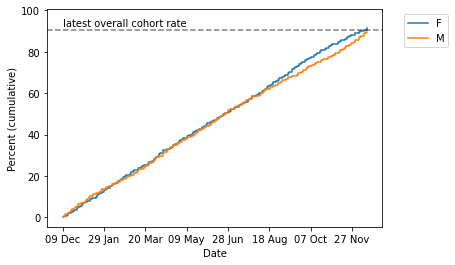

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **80+** population by **ageband 5yr**

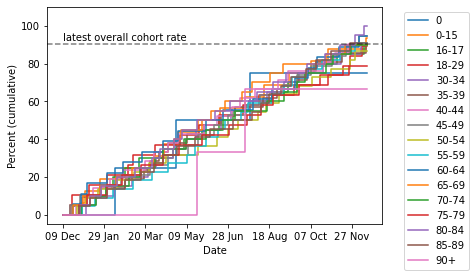

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **80+** population by **ethnicity 6 groups**

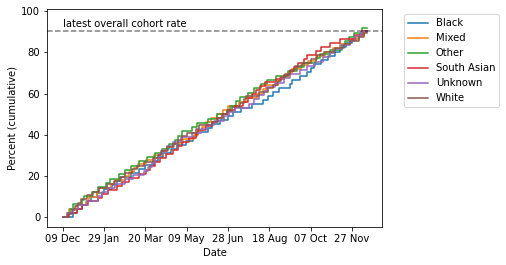

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **80+** population by **imd categories**

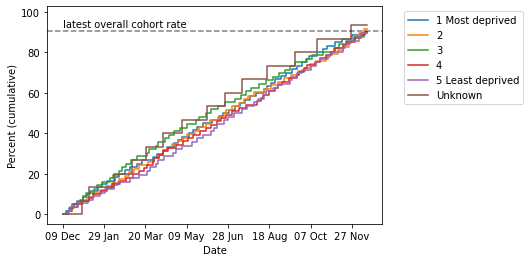

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **80+** population by **bmi**

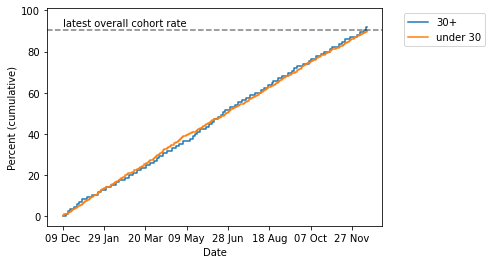

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **80+** population by **housebound**

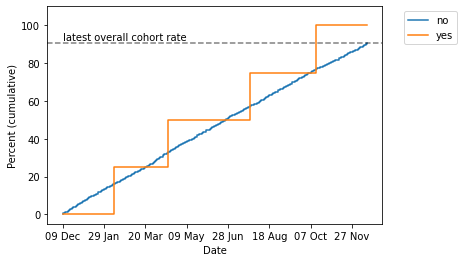

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **80+** population by **dementia**

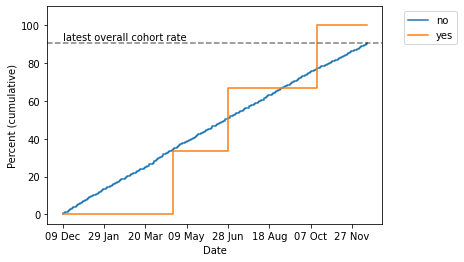

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **80+** population by **psychosis schiz bipolar**

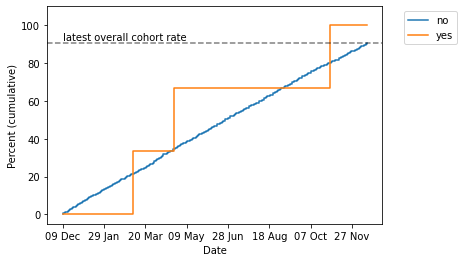

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **80+** population by **LD**

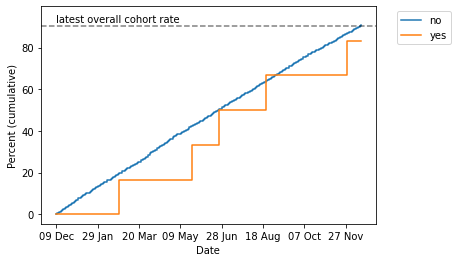

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **80+** population by **ssri**

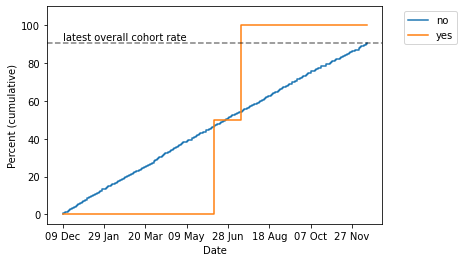

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **80+** population by **ckd**

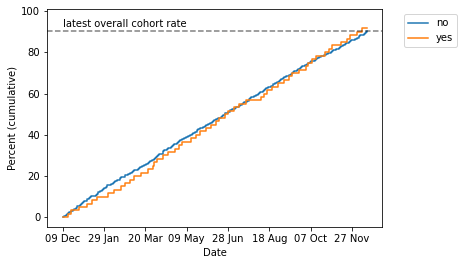

## 
 ## COVID vaccination rollout among **70-79** population up to 15 Dec 2021

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **70-79** population by **sex**

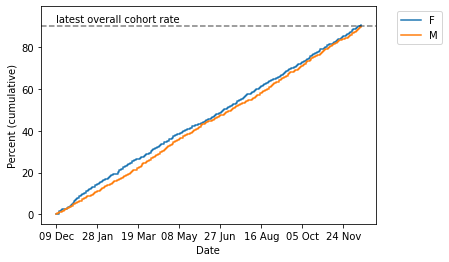

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **70-79** population by **ageband 5yr**

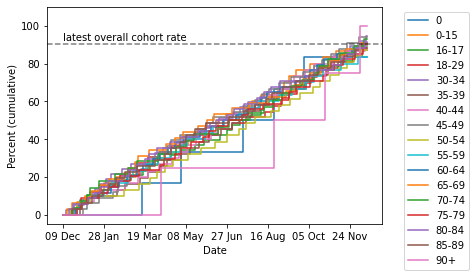

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **70-79** population by **ethnicity 6 groups**

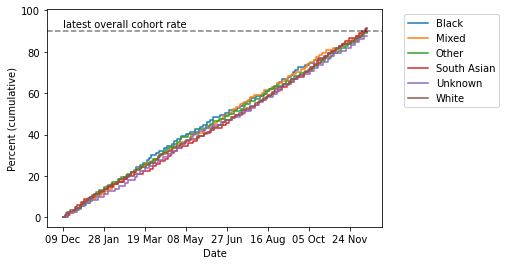

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **70-79** population by **imd categories**

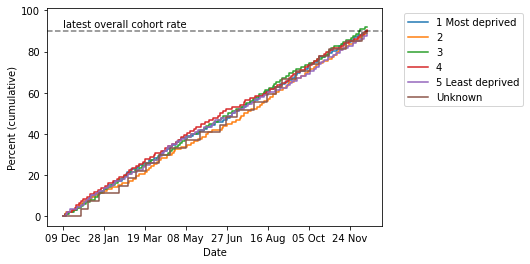

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **70-79** population by **bmi**

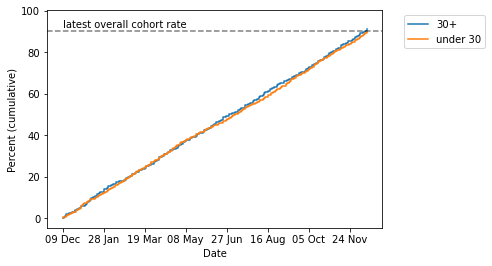

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **70-79** population by **housebound**

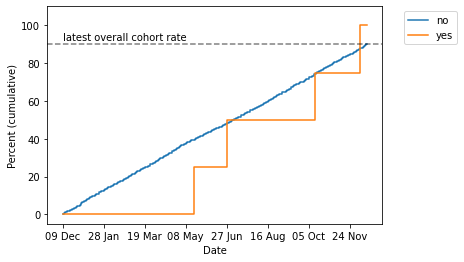

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **70-79** population by **dementia**

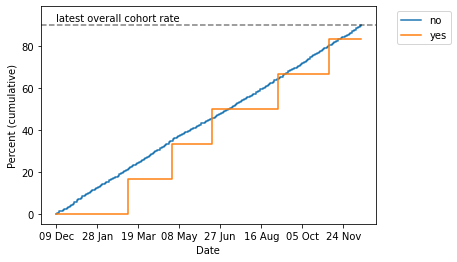

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **70-79** population by **psychosis schiz bipolar**

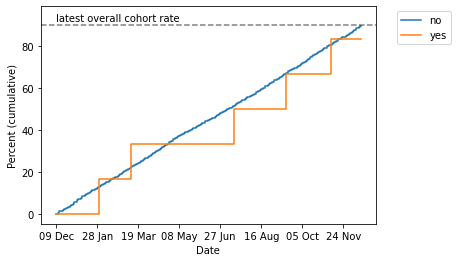

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **70-79** population by **LD**

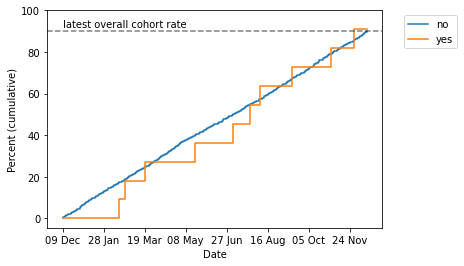

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **70-79** population by **ssri**

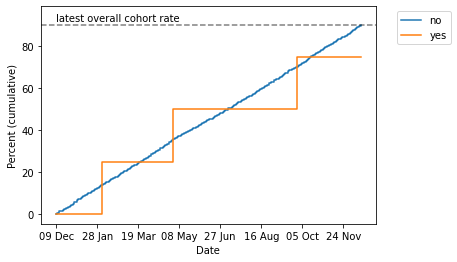

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **70-79** population by **ckd**

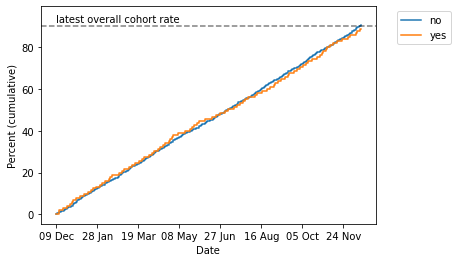

## 
 ## COVID vaccination rollout among **65-69** population up to 15 Dec 2021

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **65-69** population by **sex**

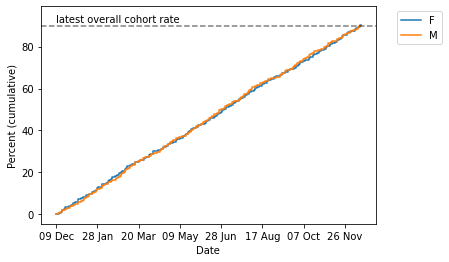

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **65-69** population by **ethnicity 6 groups**

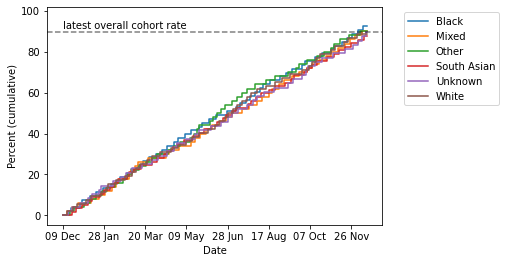

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **65-69** population by **imd categories**

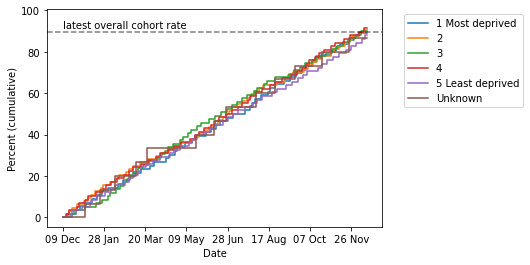

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **65-69** population by **bmi**

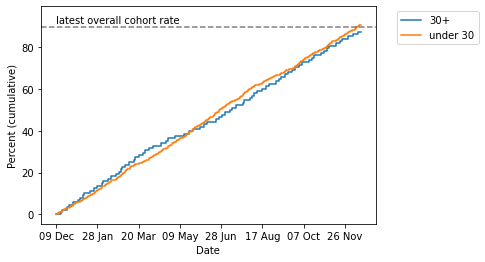

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **65-69** population by **housebound**

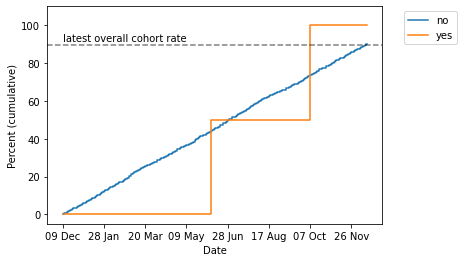

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **65-69** population by **dementia**

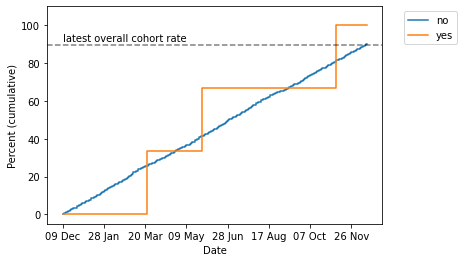

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **65-69** population by **psychosis schiz bipolar**

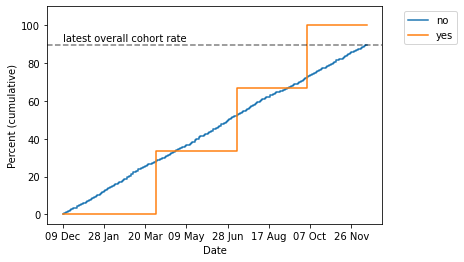

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **65-69** population by **LD**

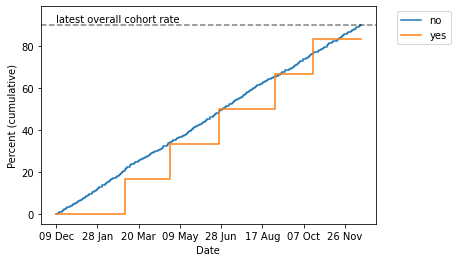

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **65-69** population by **ssri**

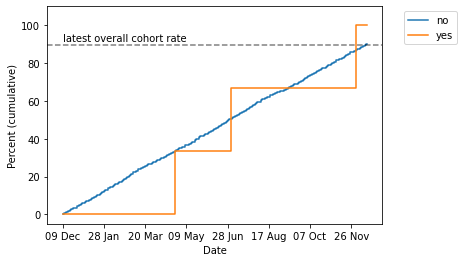

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **65-69** population by **ckd**

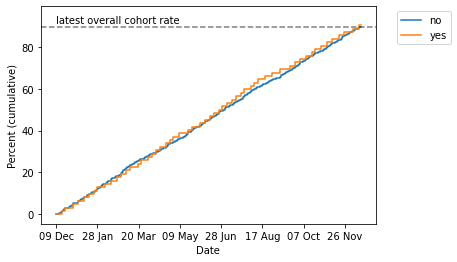

## 
 ## COVID vaccination rollout among **shielding (aged 16-69)** population up to 15 Dec 2021

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **shielding (aged 16-69)** population by **newly shielded since feb 15**

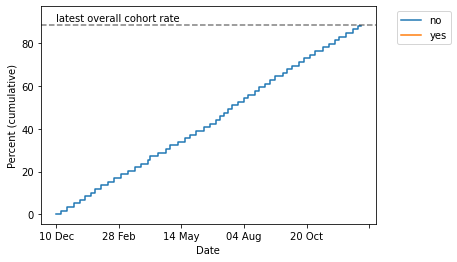

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **shielding (aged 16-69)** population by **sex**

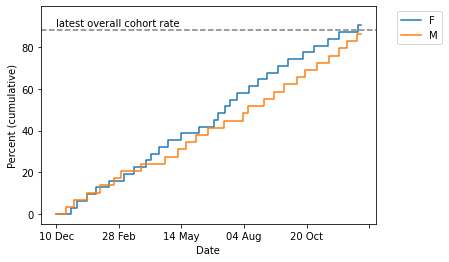

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **shielding (aged 16-69)** population by **ageband**

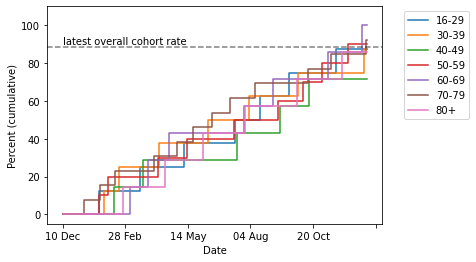

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **shielding (aged 16-69)** population by **ethnicity 6 groups**

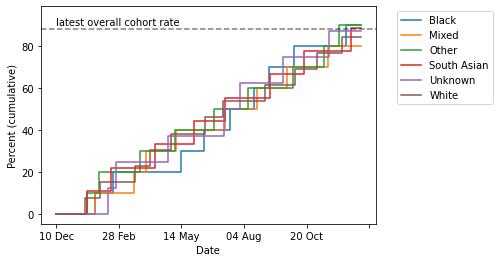

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **shielding (aged 16-69)** population by **imd categories**

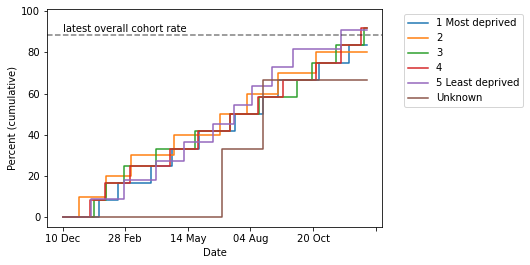

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **shielding (aged 16-69)** population by **LD**

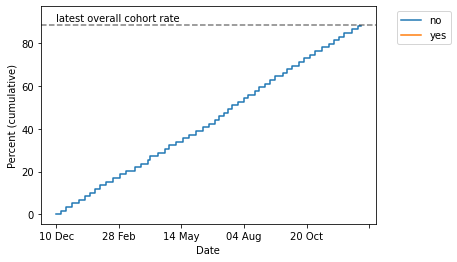

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **shielding (aged 16-69)** population by **ckd**

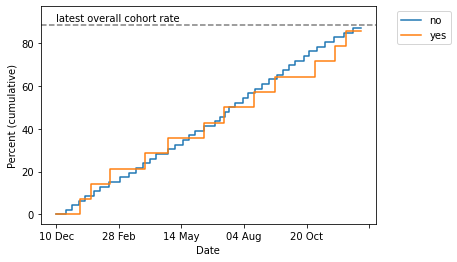

## 
 ## COVID vaccination rollout among **60-64** population up to 15 Dec 2021

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **60-64** population by **sex**

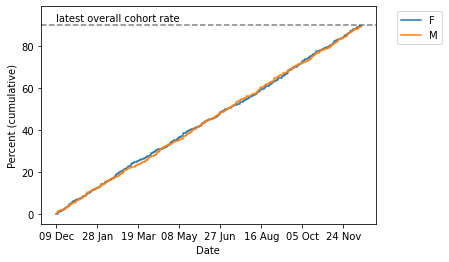

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **60-64** population by **ethnicity 6 groups**

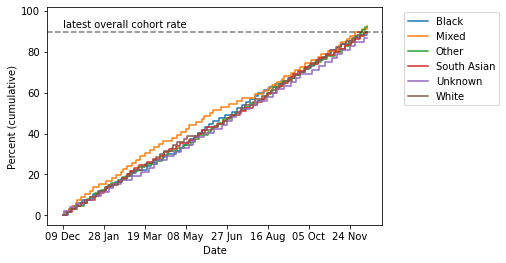

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **60-64** population by **imd categories**

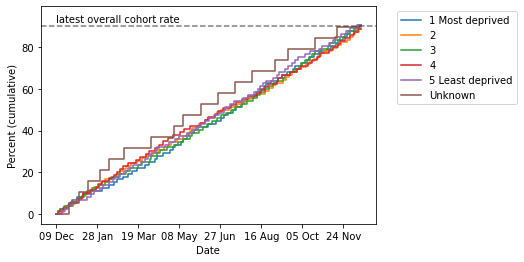

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **60-64** population by **bmi**

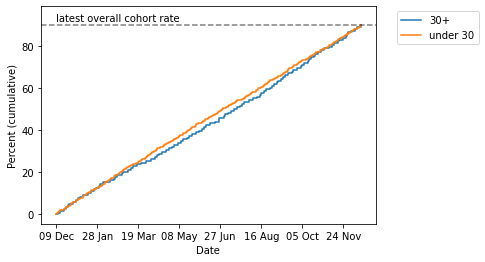

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **60-64** population by **dementia**

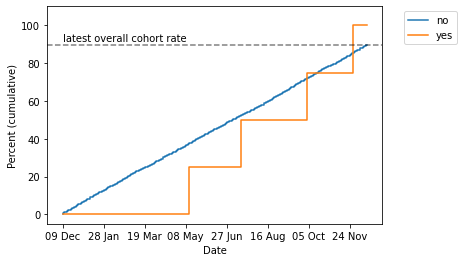

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **60-64** population by **psychosis schiz bipolar**

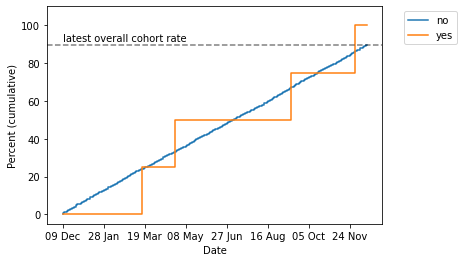

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **60-64** population by **ssri**

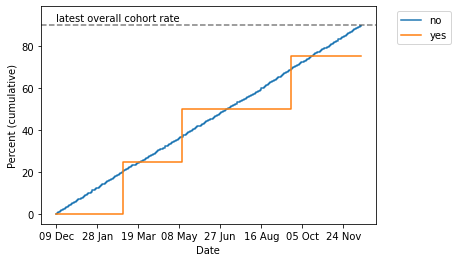

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **60-64** population by **ckd**

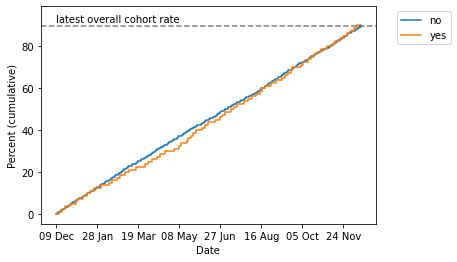

## 
 ## COVID vaccination rollout among **55-59** population up to 15 Dec 2021

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **55-59** population by **sex**

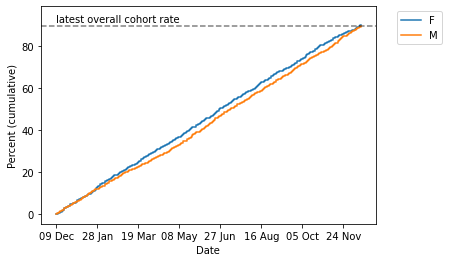

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **55-59** population by **ethnicity 6 groups**

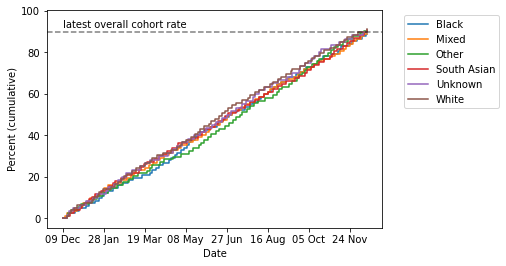

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **55-59** population by **imd categories**

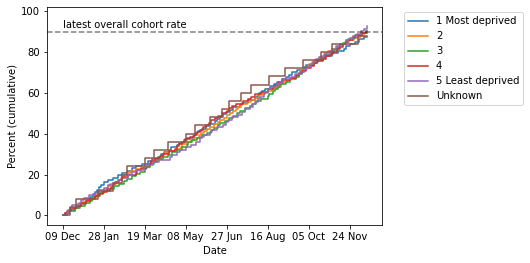

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **55-59** population by **bmi**

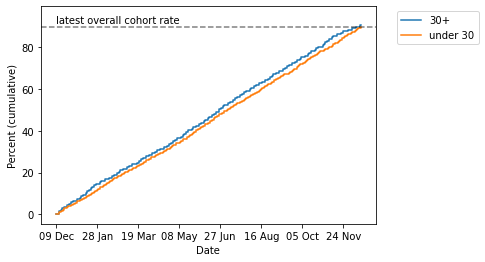

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **55-59** population by **psychosis schiz bipolar**

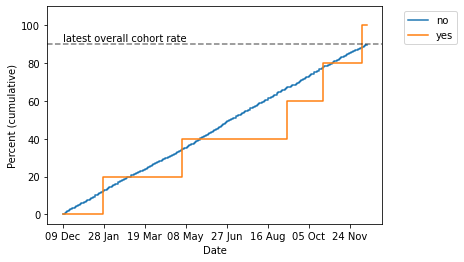

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **55-59** population by **ssri**

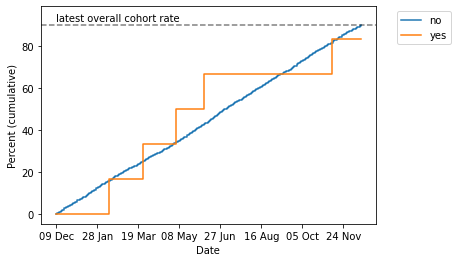

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **55-59** population by **ckd**

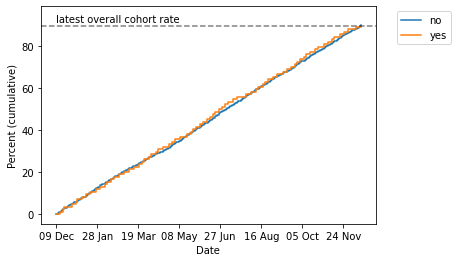

## 
 ## COVID vaccination rollout among **50-54** population up to 15 Dec 2021

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **50-54** population by **sex**

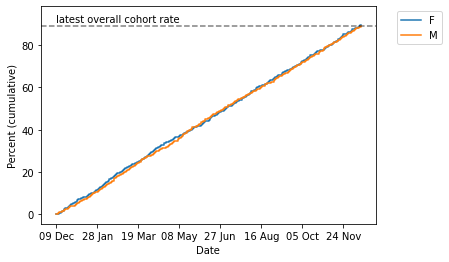

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **50-54** population by **ethnicity 6 groups**

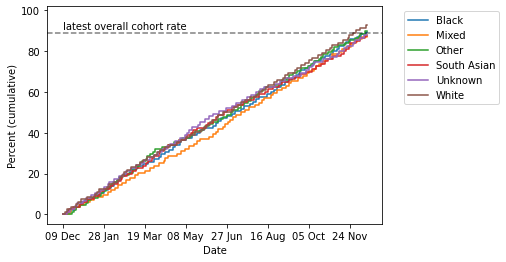

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **50-54** population by **imd categories**

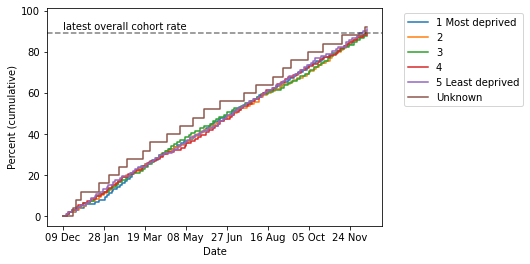

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **50-54** population by **bmi**

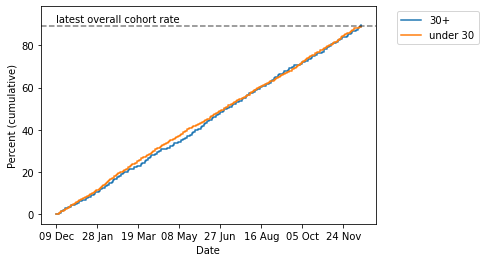

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **50-54** population by **psychosis schiz bipolar**

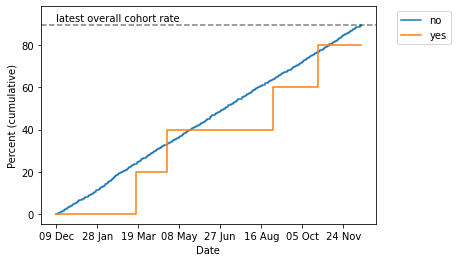

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **50-54** population by **ssri**

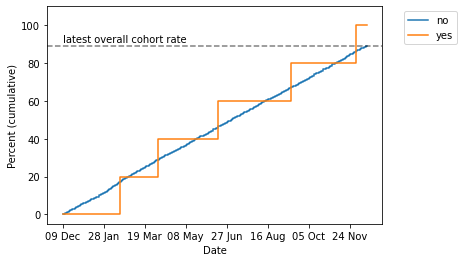

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **50-54** population by **ckd**

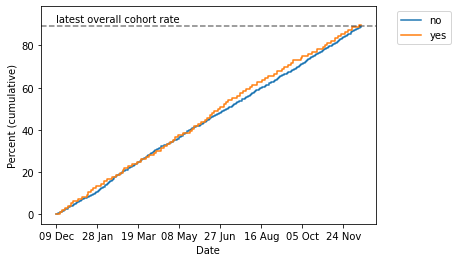

## 
 ## COVID vaccination rollout among **40-49** population up to 15 Dec 2021

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **40-49** population by **sex**

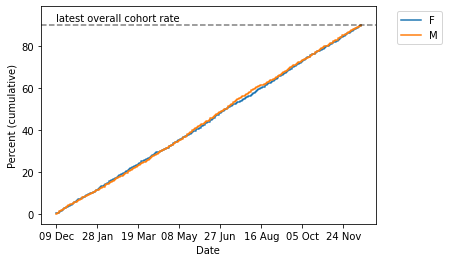

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **40-49** population by **ethnicity 6 groups**

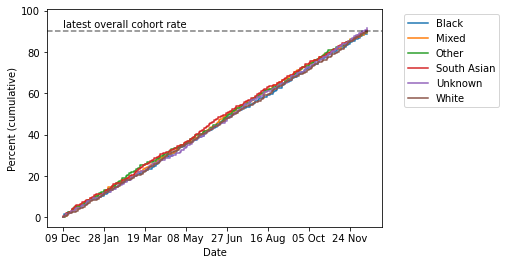

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **40-49** population by **imd categories**

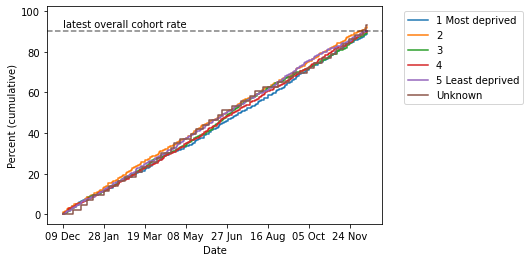

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **40-49** population by **bmi**

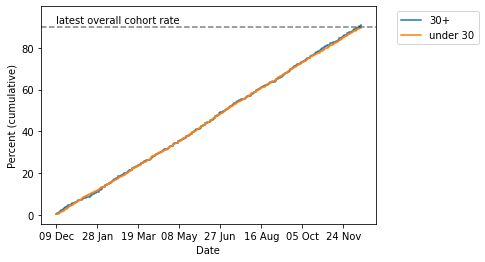

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **40-49** population by **psychosis schiz bipolar**

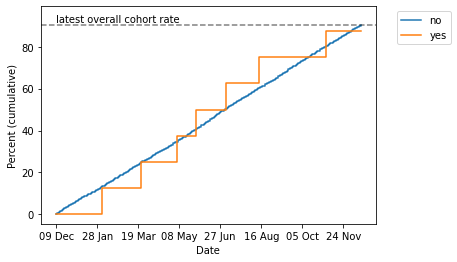

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **40-49** population by **ssri**

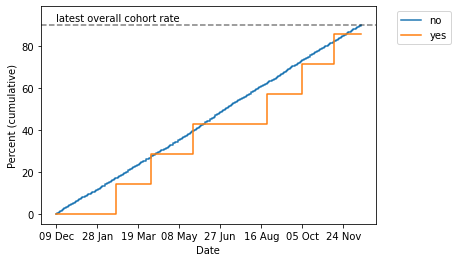

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **40-49** population by **ckd**

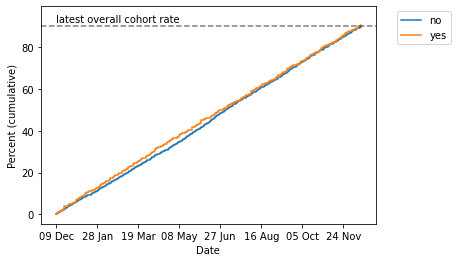

## 
 ## COVID vaccination rollout among **30-39** population up to 15 Dec 2021

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **30-39** population by **sex**

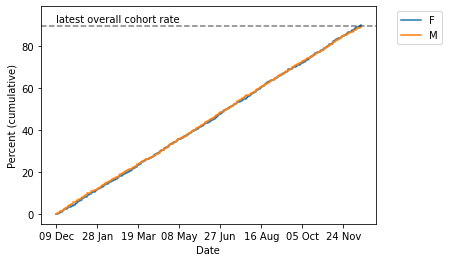

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **30-39** population by **ethnicity 6 groups**

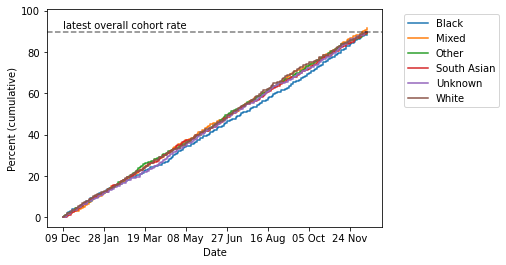

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **30-39** population by **imd categories**

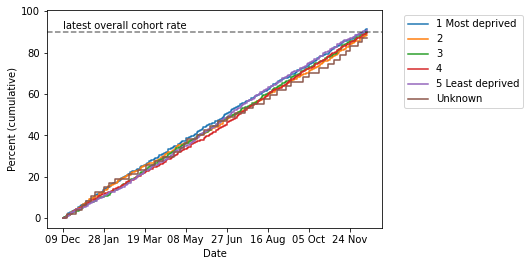

## 
 ## COVID vaccination rollout among **18-29** population up to 15 Dec 2021

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **18-29** population by **sex**

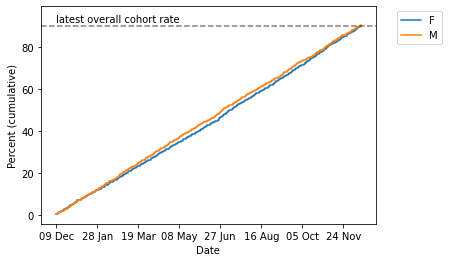

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **18-29** population by **ethnicity 6 groups**

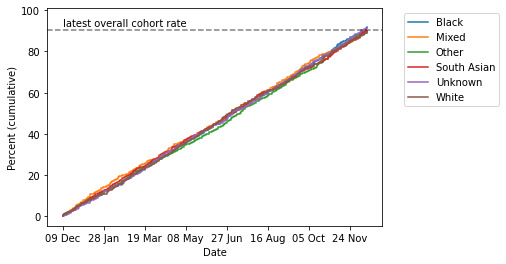

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:722: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.drop([c2, f"{c2}_total"],1)


### COVID vaccinations among **18-29** population by **imd categories**

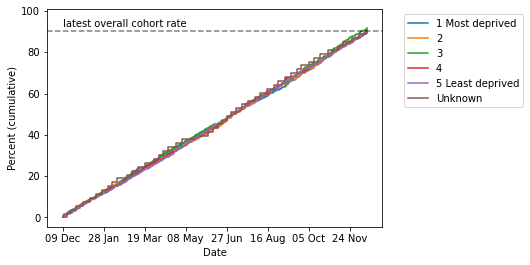

In [27]:
plot_dem_charts(summ_stat_results, df_dict_cum,  formatted_latest_date, pop_subgroups=["80+", "70-79", "65-69","shielding (aged 16-69)", "60-64", "55-59", "50-54", "40-49", "30-39", "18-29"], groups_dict=features_dict,
                groups_to_exclude=["ethnicity_16_groups", "current_copd", "chronic_cardiac_disease", "dmards", "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer"],
                savepath=savepath, savepath_figure_csvs=savepath_figure_csvs, suffix=suffix)

## Completeness of ethnicity recording

In [28]:
from data_quality import *

ethnicity_completeness(df=df, groups_of_interest=population_subgroups)


Total **80+** population with ethnicity recorded 1,792 (83.7%)

Total **70-79** population with ethnicity recorded 2,982 (85.7%)

Total **care home** population with ethnicity recorded 1,183 (84.9%)

Total **shielding (aged 16-69)** population with ethnicity recorded 364 (86.7%)

Total **65-69** population with ethnicity recorded 1,834 (84.5%)

Total **LD (aged 16-64)** population with ethnicity recorded 679 (84.3%)

Total **60-64** population with ethnicity recorded 2,310 (86.4%)

Total **55-59** population with ethnicity recorded 2,765 (86.8%)

Total **50-54** population with ethnicity recorded 2,933 (84.8%)

Total **40-49** population with ethnicity recorded 5,236 (85.3%)

Total **30-39** population with ethnicity recorded 5,418 (85.0%)

Total **18-29** population with ethnicity recorded 6,258 (84.3%)

Total **16-17** population with ethnicity recorded 8,764 (84.7%)

# Second doses

In [29]:
# only count second doses where the first dose was given at least 14 weeks ago 
# to allow comparison of the first dose situation 14w ago with the second dose situation now
# otherwise bias could be introduced from any second doses given early in certain subgroups

def subtract_from_date(s, unit, number, description):
    '''
    s (series): a series of date-like strings
    unit (str) : days/weeks
    number (int): number of days/weeks to subtract
    description (str): description of new date calculated to use as filename
    '''
    if unit == "weeks":
        new_date = pd.to_datetime(s).max() - timedelta(weeks=number)
    elif unit == "days":
        new_date = pd.to_datetime(s).max() - timedelta(days=number)
    else:
        display("invalid unit")
        return
    new_date = str(new_date)[:10]

    formatted_date = datetime.strptime(new_date, "%Y-%m-%d").strftime("%d %b %Y")
    with open(os.path.join(savepath["text"], f"{description}.txt"), "w") as text_file:
            text_file.write(formatted_date)
    with open(os.path.join(savepath["text"], f"{description}_specified_delay.txt"), "w") as text_file:
        formatted_delay = f"{number} {unit}"
        text_file.write(formatted_delay)

    display(Markdown(formatted_date))
    return new_date, formatted_date
    

date_14w, formatted_date_14w = subtract_from_date(s=df["covid_vacc_date"], unit="weeks", number=14,
                                             description="latest_date_of_first_dose_for_due_second_doses")


08 Sep 2021

In [30]:
# filter data
df_s = df.copy()
# replace any second doses not yet "due" with "0"
df_s.loc[(pd.to_datetime(df_s["covid_vacc_date"]) >= date_14w), "covid_vacc_second_dose_date"] = 0

# also ensure that first dose was dated after the start of the campaign, otherwise date is likely incorrect 
# and due date for second dose cannot be calculated accurately
# this also excludes any second doses where first dose date = 0 (this should affect dummy data only!)
df_s.loc[(pd.to_datetime(df_s["covid_vacc_date"]) <= "2020-12-07"), "covid_vacc_second_dose_date"] = 0

In [31]:
# add "brand of first dose" to list of features to break down by
import copy
features_dict_2 = copy.deepcopy(features_dict)

for k in features_dict_2:
    ls = list(features_dict_2[k])
    ls.append("brand_of_first_dose") 
    features_dict_2[k] = ls

In [32]:
# data processing / summarising
df_dict_cum_second_dose = cumulative_sums(df_s, groups_of_interest=population_subgroups, features_dict=features_dict_2, 
                                          latest_date=latest_date, reference_column_name="covid_vacc_second_dose_date")

second_dose_summarised_data_dict = summarise_data_by_group(df_dict_cum_second_dose, latest_date=latest_date, groups=groups)

create_detailed_summary_uptake(second_dose_summarised_data_dict, formatted_latest_date, 
                               groups=groups,
                               savepath=savepath, vaccine_type="second_dose")

# ## For comparison look at first doses UP TO 14 WEEKS AGO
#

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:192: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out2 = out2.rename(columns={0:"overall"}).drop(["level_0"],1)
/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:412: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.transpose().append(date_reached).transpose().drop("weeks_to_target",1)
/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:422: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out2 = out2.loc[out2[reference_column_name]==latest_d

## 

## COVID vaccination rollout (second dose) among **80+** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1176   
sex                       F                                           616   
                          M                                           560   
ageband_5yr               0                                            14   
                          0-15                                         63   
                          16-17                                        77   
                          18-29                                        70   
                          30-34                                        77   
                          35-39                                        77   
                          40-44                                        91   
                          45-49                                        70   
                          50-54                                        77   
                          55-59                                        77   
                          60-64                                        63   
                          65-69                                        91   
                          70-74                                        70   
                          75-79                                        63   
                          80-84                                        91   
                          85-89                                        91   
                          90+                                           7   
ethnicity_6_groups        Black                                       189   
                          Mixed                                       196   
                          Other                                       182   
                          South Asian                                 203   
                          Unknown                                     182   
                          White                                       224   
ethnicity_16_groups        African                                     63   
                           Bangladeshi or British Bangladeshi          56   
                           Caribbean                                   63   
                           Chinese                                     49   
                           Other                                       77   
                           Other Asian                                 63   
                          British or Mixed British                     77   
                          Indian or British Indian                     63   
                          Irish                                        70   
                          Other Black                                  42   
                          Other White                                  63   
                          Other mixed                                  49   
                          Pakistani or British Pakistani               56   
                          Unknown                                     175   
                          White + Asian                                63   
                          White + Black African                        56   
                          White + Black Caribbean                      84   
imd_categories            1 Most deprived                             231   
                          2                                           224   
                          3                                           224   
                          4                                           231   
                          5 Least deprived                            210   
                          Unknown                                      63   
bmi                       30+                                         315   
                          under 30                         

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose) among **70-79** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1813   
sex                       F                                           931   
                          M                                           882   
ageband_5yr               0                                            21   
                          0-15                                        119   
                          16-17                                       140   
                          18-29                                       112   
                          30-34                                       147   
                          35-39                                       112   
                          40-44                                        98   
                          45-49                                       126   
                          50-54                                       105   
                          55-59                                       105   
                          60-64                                       126   
                          65-69                                       119   
                          70-74                                       105   
                          75-79                                       119   
                          80-84                                       126   
                          85-89                                       112   
                          90+                                          14   
ethnicity_6_groups        Black                                       322   
                          Mixed                                       322   
                          Other                                       308   
                          South Asian                                 280   
                          Unknown                                     266   
                          White                                       322   
ethnicity_16_groups        African                                    112   
                           Bangladeshi or British Bangladeshi          84   
                           Caribbean                                   98   
                           Chinese                                     91   
                           Other                                       91   
                           Other Asian                                 91   
                          British or Mixed British                     84   
                          Indian or British Indian                     91   
                          Irish                                        84   
                          Other Black                                 105   
                          Other White                                  91   
                          Other mixed                                  98   
                          Pakistani or British Pakistani               98   
                          Unknown                                     294   
                          White + Asian                               105   
                          White + Black African                       105   
                          White + Black Caribbean                      84   
imd_categories            1 Most deprived                             322   
                          2                                           343   
                          3                                           371   
                          4                                           364   
                          5 Least deprived                            308   
                          Unknown                                      98   
bmi                       30+                                         567   
                          under 30                         

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose) among **care home** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                     
overall             overall             749     53.8   1393   
sex                 F                   399     55.3    721   
                    M                   350     52.1    672   
ageband_5yr         0                     7     50.0     14   
                    0-15                 56     61.5     91   
                    16-17                49     50.0     98   
                    18-29                42     50.0     84   
                    30-34                42     50.0     84   
                    35-39                49     50.0     98   
                    40-44                49     50.0     98   
                    45-49                49     53.8     91   
                    50-54                49     58.3     84   
                    55-59                49     53.8     91   
                    60-64                49     53.8     91   
                    65-69                49     58.3     84   
                    70-74                56     53.3    105   
                    75-79                56     61.5     91   
                    80-84                35     45.5     77   
                    85-89                49     50.0     98   
                    90+                   0      0.0     14   
ethnicity_6_groups  Black               133     59.4    224   
                    Mixed               133     52.8    252   
                    Other               119     56.7    210   
                    South Asian         140     52.6    266   
                    Unknown             105     50.0    210   
                    White               119     51.5    231   
dementia            no                  749     54.3   1379   
                    yes                   0      0.0     14   
brand_of_first_dose Oxford-AZ             0      0.0      0   
                    Pfizer                0      0.0      0   
                    Unknown             749     59.8   1253   

                                vaccinated 7d previous (percent)  \
category            group                                          
overall             overall                                 52.8   
sex                 F                                       53.4   
                    M                                       52.1   
ageband_5yr         0                                       50.0   
                    0-15                                    61.5   
                    16-17                                   50.0   
                    18-29                                   50.0   
                    30-34                                   50.0   
                    35-39                                   50.0   
                    40-44                                   42.9   
                    45-49                                   53.8   
                    50-54                                   58.3   
                    55-59                                   53.8   
                    60-64                                   46.2   
                    65-69                                   50.0   
                    70-74                                   53.3   
                    75-79                                   61.5   
                    80-84                                   45.5   
                    85-89                                   50.0   
                    90+                                      0.0   
ethnicity_6_groups  Black                                   59.4   
                    Mixed                                   52.8   
                    Other                                   53.3   
                    South Asian                             50.0   
                    Unknown                                 50.0   
                    White                                   51.5   
dementia            no                           

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose) among **shielding (aged 16-69)** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                  217     51.7    420   
newly_shielded_since_feb_15 no                       217     52.5    413   
                            yes                        0      0.0      0   
sex                         F                        119     54.8    217   
                            M                         98     48.3    203   
ageband                     16-29                     28     50.0     56   
                            30-39                     28     50.0     56   
                            40-49                     21     42.9     49   
                            50-59                     35     50.0     70   
                            60-69                     28     57.1     49   
                            70-79                     56     61.5     91   
                            80+                       21     42.9     49   
ethnicity_6_groups          Black                     42     60.0     70   
                            Mixed                     35     50.0     70   
                            Other                     35     50.0     70   
                            South Asian               35     55.6     63   
                            Unknown                   28     50.0     56   
                            White                     42     46.2     91   
imd_categories              1 Most deprived           35     41.7     84   
                            2                         42     60.0     70   
                            3                         42     50.0     84   
                            4                         42     50.0     84   
                            5 Least deprived          42     54.5     77   
                            Unknown                    7     33.3     21   
LD                          no                       210     50.8    413   
                            yes                        0      0.0      0   
ckd                         no                       168     52.2    322   
                            yes                       42     42.9     98   
brand_of_first_dose         Pfizer                     0      0.0      0   
                            Unknown                  217     59.6    364   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                      50.0   
newly_shielded_since_feb_15 no                                           50.8   
                            yes                                           NaN   
sex                         F                                            51.6   
                            M                                            48.3   
ageband                     16-29                                        50.0   
                            30-39                                        50.0   
                            40-49                                        42.9   
                            50-59                                        50.0   
                            60-69                                        57.1   
                            70-79                                        61.5   
                            80+                                          42.9   
ethnicity_6_groups          Black                                        60.0   
                            Mixed                                        50.0   
                            Other                                        50.0   
                            South Asian                                  55.6   
                            Unknown                                      50.0   
                            White                                        3

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose) among **65-69** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1141   
sex                       F                                           560   
                          M                                           581   
ethnicity_6_groups        Black                                       210   
                          Mixed                                       182   
                          Other                                       189   
                          South Asian                                 203   
                          Unknown                                     168   
                          White                                       189   
ethnicity_16_groups        African                                     70   
                           Bangladeshi or British Bangladeshi          63   
                           Caribbean                                   49   
                           Chinese                                     56   
                           Other                                       70   
                           Other Asian                                 63   
                          British or Mixed British                     56   
                          Indian or British Indian                     56   
                          Irish                                        63   
                          Other Black                                  56   
                          Other White                                  63   
                          Other mixed                                  42   
                          Pakistani or British Pakistani               77   
                          Unknown                                     161   
                          White + Asian                                63   
                          White + Black African                        63   
                          White + Black Caribbean                      77   
imd_categories            1 Most deprived                             203   
                          2                                           238   
                          3                                           217   
                          4                                           224   
                          5 Least deprived                            203   
                          Unknown                                      56   
bmi                       30+                                         308   
                          under 30                                    833   
housebound                no                                         1134   
                          yes                                           7   
chronic_cardiac_disease   no                                         1120   
                          yes                                          21   
current_copd              no                                         1127   
                          yes                                          14   
dmards                    no                                         1134   
                          yes                                           7   
dementia                  no                                         1134   
                          yes                                          14   
psychosis_schiz_bipolar   no                                         1134   
                          yes                                          14   
LD                        no                                         1120   
                          yes                                          21   
ssri                      no                                         1127   
                          yes                                          14   
chemo_or_radio            no                               

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose) among **LD (aged 16-64)** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                     
overall             overall             413     51.3    805   
sex                 F                   210     50.8    413   
                    M                   203     51.8    392   
ageband_5yr         0                     0      0.0      7   
                    0-15                 21     42.9     49   
                    16-17                21     42.9     49   
                    18-29                21     42.9     49   
                    30-34                21     50.0     42   
                    35-39                28     57.1     49   
                    40-44                35     71.4     49   
                    45-49                28     50.0     56   
                    50-54                35     62.5     56   
                    55-59                28     57.1     49   
                    60-64                28     50.0     56   
                    65-69                35     55.6     63   
                    70-74                28     57.1     49   
                    75-79                21     33.3     63   
                    80-84                28     57.1     49   
                    85-89                28     57.1     49   
                    90+                   0      0.0      7   
ethnicity_6_groups  Black                70     55.6    126   
                    Mixed                77     47.8    161   
                    Other                63     47.4    133   
                    South Asian          63     47.4    133   
                    Unknown              70     55.6    126   
                    White                70     55.6    126   
brand_of_first_dose Oxford-AZ             0      0.0      0   
                    Unknown             413     56.7    728   

                                vaccinated 7d previous (percent)  \
category            group                                          
overall             overall                                 50.4   
sex                 F                                       50.8   
                    M                                       50.0   
ageband_5yr         0                                        0.0   
                    0-15                                    28.6   
                    16-17                                   42.9   
                    18-29                                   42.9   
                    30-34                                   50.0   
                    35-39                                   57.1   
                    40-44                                   71.4   
                    45-49                                   50.0   
                    50-54                                   62.5   
                    55-59                                   57.1   
                    60-64                                   50.0   
                    65-69                                   55.6   
                    70-74                                   57.1   
                    75-79                                   33.3   
                    80-84                                   57.1   
                    85-89                                   57.1   
                    90+                                      0.0   
ethnicity_6_groups  Black                                   55.6   
                    Mixed                                   47.8   
                    Other                                   47.4   
                    South Asian                             47.4   
                    Unknown                                 55.6   
                    White                                   55.6   
brand_of_first_dose Oxford-AZ                                NaN   
                    Unknown                                 55.8   

                                Uptake over last 7d (percent)  \
category            group           

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose) among **60-64** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1393   
sex                       F                                           693   
                          M                                           700   
ethnicity_6_groups        Black                                       252   
                          Mixed                                       259   
                          Other                                       238   
                          South Asian                                 224   
                          Unknown                                     182   
                          White                                       245   
ethnicity_16_groups        African                                     56   
                           Bangladeshi or British Bangladeshi          84   
                           Caribbean                                   70   
                           Chinese                                     84   
                           Other                                       84   
                           Other Asian                                 70   
                          British or Mixed British                     70   
                          Indian or British Indian                     70   
                          Irish                                        91   
                          Other Black                                  70   
                          Other White                                  77   
                          Other mixed                                  77   
                          Pakistani or British Pakistani               77   
                          Unknown                                     217   
                          White + Asian                                70   
                          White + Black African                        63   
                          White + Black Caribbean                      70   
imd_categories            1 Most deprived                             266   
                          2                                           273   
                          3                                           245   
                          4                                           259   
                          5 Least deprived                            273   
                          Unknown                                      77   
bmi                       30+                                         427   
                          under 30                                    959   
chronic_cardiac_disease   no                                         1372   
                          yes                                          21   
current_copd              no                                         1379   
                          yes                                           7   
dmards                    no                                         1379   
                          yes                                           7   
dementia                  no                                         1372   
                          yes                                          14   
psychosis_schiz_bipolar   no                                         1379   
                          yes                                          14   
ssri                      no                                         1379   
                          yes                                          14   
chemo_or_radio            no                                         1372   
                          yes                                          14   
lung_cancer               no                                         1379   
                          yes                                          14   
cancer_excl_lung_and_haem no                               

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose) among **55-59** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    1708   
sex                     F                                           910   
                        M                                           798   
ethnicity_6_groups      Black                                       308   
                        Mixed                                       308   
                        Other                                       259   
                        South Asian                                 287   
                        Unknown                                     231   
                        White                                       308   
ethnicity_16_groups      African                                    105   
                         Bangladeshi or British Bangladeshi          91   
                         Caribbean                                   98   
                         Chinese                                     91   
                         Other                                       77   
                         Other Asian                                 77   
                        British or Mixed British                     91   
                        Indian or British Indian                     84   
                        Irish                                        91   
                        Other Black                                  91   
                        Other White                                  84   
                        Other mixed                                  91   
                        Pakistani or British Pakistani              112   
                        Unknown                                     252   
                        White + Asian                                91   
                        White + Black African                        91   
                        White + Black Caribbean                      84   
imd_categories          1 Most deprived                             336   
                        2                                           336   
                        3                                           315   
                        4                                           322   
                        5 Least deprived                            301   
                        Unknown                                      98   
bmi                     30+                                         546   
                        under 30                                   1162   
chronic_cardiac_disease no                                         1687   
                        yes                                          21   
current_copd            no                                         1687   
                        yes                                          14   
dmards                  no                                         1694   
                        yes                                          14   
psychosis_schiz_bipolar no                                         1694   
                        yes                                          14   
ssri                    no                                         1687   
                        yes                                          21   
ckd                     no                                         1393   
                        yes                                         315   
brand_of_first_dose     Oxford-AZ                                     0   
                        Pfizer                                        0   
                        Unknown                                    1701   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 53.6   3185  

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose) among **50-54** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    1778   
sex                     F                                           924   
                        M                                           854   
ethnicity_6_groups      Black                                       294   
                        Mixed                                       294   
                        Other                                       315   
                        South Asian                                 294   
                        Unknown                                     273   
                        White                                       308   
ethnicity_16_groups      African                                     98   
                         Bangladeshi or British Bangladeshi          84   
                         Caribbean                                  105   
                         Chinese                                    105   
                         Other                                      105   
                         Other Asian                                 84   
                        British or Mixed British                     84   
                        Indian or British Indian                     84   
                        Irish                                        91   
                        Other Black                                  84   
                        Other White                                  84   
                        Other mixed                                  91   
                        Pakistani or British Pakistani              105   
                        Unknown                                     280   
                        White + Asian                                91   
                        White + Black African                       112   
                        White + Black Caribbean                      91   
imd_categories          1 Most deprived                             343   
                        2                                           336   
                        3                                           329   
                        4                                           343   
                        5 Least deprived                            329   
                        Unknown                                      98   
bmi                     30+                                         532   
                        under 30                                   1246   
chronic_cardiac_disease no                                         1764   
                        yes                                          14   
current_copd            no                                         1764   
                        yes                                          14   
dmards                  no                                         1764   
                        yes                                          14   
psychosis_schiz_bipolar no                                         1764   
                        yes                                          14   
ssri                    no                                         1757   
                        yes                                          21   
ckd                     no                                         1421   
                        yes                                         357   
brand_of_first_dose     Oxford-AZ                                     0   
                        Pfizer                                        0   
                        Unknown                                    1771   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 51.4   3458  

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose) among **40-49** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    3269   
sex                     F                                          1666   
                        M                                          1610   
ethnicity_6_groups      Black                                       525   
                        Mixed                                       581   
                        Other                                       553   
                        South Asian                                 574   
                        Unknown                                     455   
                        White                                       574   
ethnicity_16_groups      African                                    168   
                         Bangladeshi or British Bangladeshi         168   
                         Caribbean                                  168   
                         Chinese                                    196   
                         Other                                      175   
                         Other Asian                                175   
                        British or Mixed British                    175   
                        Indian or British Indian                    161   
                        Irish                                       182   
                        Other Black                                 189   
                        Other White                                 175   
                        Other mixed                                 154   
                        Pakistani or British Pakistani              154   
                        Unknown                                     511   
                        White + Asian                               182   
                        White + Black African                       168   
                        White + Black Caribbean                     161   
imd_categories          1 Most deprived                             581   
                        2                                           623   
                        3                                           623   
                        4                                           609   
                        5 Least deprived                            665   
                        Unknown                                     161   
bmi                     30+                                        1015   
                        under 30                                   2261   
chronic_cardiac_disease no                                         3234   
                        yes                                          35   
current_copd            no                                         3241   
                        yes                                          35   
dmards                  no                                         3241   
                        yes                                          35   
psychosis_schiz_bipolar no                                         3241   
                        yes                                          28   
ssri                    no                                         3255   
                        yes                                          14   
ckd                     no                                         2604   
                        yes                                         665   
brand_of_first_dose     Moderna                                       0   
                        Oxford-AZ                                     0   
                        Pfizer                                        0   
                        Unknown                                    3262   

                                                             percent  total  \
category                group                                                 
ov

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose) among **30-39** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    3353     52.6   
sex                 F                                          1736     52.7   
                    M                                          1617     52.5   
ethnicity_6_groups  Black                                       518     48.4   
                    Mixed                                       581     54.2   
                    Other                                       602     53.8   
                    South Asian                                 574     51.2   
                    Unknown                                     504     52.6   
                    White                                       581     56.1   
ethnicity_16_groups  African                                    168     50.0   
                     Bangladeshi or British Bangladeshi         175     53.2   
                     Caribbean                                  168     51.1   
                     Chinese                                    196     54.9   
                     Other                                      210     56.6   
                     Other Asian                                182     54.2   
                    British or Mixed British                    189     57.4   
                    Indian or British Indian                    203     54.7   
                    Irish                                       161     51.1   
                    Other Black                                 168     55.8   
                    Other White                                 189     52.9   
                    Other mixed                                 196     53.8   
                    Pakistani or British Pakistani              168     50.0   
                    Unknown                                     483     51.9   
                    White + Asian                               161     51.1   
                    White + Black African                       168     50.0   
                    White + Black Caribbean                     182     52.0   
imd_categories      1 Most deprived                             637     53.2   
                    2                                           623     50.9   
                    3                                           658     53.7   
                    4                                           644     51.4   
                    5 Least deprived                            630     55.2   
                    Unknown                                     168     51.1   
brand_of_first_dose Moderna                                       0      0.0   
                    Oxford-AZ                                     0      0.0   
                    Pfizer                                        0      0.0   
                    Unknown                                    3346     58.7   

                                                         total  \
category            group                                        
overall             overall                               6377   
sex                 F                                     3297   
                    M                                     3080   
ethnicity_6_groups  Black                                 1071   
                    Mixed                                 1071   
                    Other                                 1120   
                    South Asian                           1120   
                    Unknown                                959   
                    White                                 1036   
ethnicity_16_groups  African                               336   
                     Bangladeshi or British Bangladeshi    329   
                     Caribbean                             329   
                     Chinese                               357   
                     Other

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose) among **18-29** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    3864     52.1   
sex                 F                                          1981     52.1   
                    M                                          1890     52.3   
ethnicity_6_groups  Black                                       672     52.7   
                    Mixed                                       630     53.3   
                    Other                                       658     51.4   
                    South Asian                                 651     52.0   
                    Unknown                                     595     51.5   
                    White                                       658     51.9   
ethnicity_16_groups  African                                    203     53.7   
                     Bangladeshi or British Bangladeshi         196     49.1   
                     Caribbean                                  182     50.0   
                     Chinese                                    210     53.6   
                     Other                                      175     47.2   
                     Other Asian                                217     51.7   
                    British or Mixed British                    210     51.7   
                    Indian or British Indian                    182     46.4   
                    Irish                                       217     52.5   
                    Other Black                                 217     50.0   
                    Other White                                 231     55.9   
                    Other mixed                                 217     54.4   
                    Pakistani or British Pakistani              224     56.1   
                    Unknown                                     588     53.5   
                    White + Asian                               196     52.8   
                    White + Black African                       231     54.1   
                    White + Black Caribbean                     182     52.0   
imd_categories      1 Most deprived                             735     50.7   
                    2                                           721     51.5   
                    3                                           749     52.7   
                    4                                           707     53.2   
                    5 Least deprived                            749     51.7   
                    Unknown                                     203     54.7   
brand_of_first_dose Moderna                                       0      0.0   
                    Oxford-AZ                                     0      0.0   
                    Pfizer                                        0      0.0   
                    Unknown                                    3850     57.7   

                                                         total  \
category            group                                        
overall             overall                               7420   
sex                 F                                     3801   
                    M                                     3612   
ethnicity_6_groups  Black                                 1274   
                    Mixed                                 1183   
                    Other                                 1281   
                    South Asian                           1253   
                    Unknown                               1155   
                    White                                 1267   
ethnicity_16_groups  African                               378   
                     Bangladeshi or British Bangladeshi    399   
                     Caribbean                             364   
                     Chinese                               392   
                     Other

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose) among **16-17** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                          
overall             overall                 5509     53.2  10346   
sex                 F                       2765     52.2   5292   
                    M                       2751     54.5   5047   
ethnicity_6_groups  Black                    952     54.2   1757   
                    Mixed                    917     51.6   1778   
                    Other                    931     53.4   1743   
                    South Asian              931     53.6   1736   
                    Unknown                  847     53.8   1575   
                    White                    938     53.6   1750   
imd_categories      1 Most deprived         1001     53.8   1862   
                    2                       1078     54.4   1981   
                    3                       1029     51.4   2002   
                    4                       1071     52.9   2023   
                    5 Least deprived        1043     53.2   1960   
                    Unknown                  294     56.8    518   
brand_of_first_dose Moderna                    0      0.0      0   
                    Oxford-AZ                  7     50.0     14   
                    Pfizer                    14     66.7     21   
                    Unknown                 5488     58.9   9317   

                                     vaccinated 7d previous (percent)  \
category            group                                               
overall             overall                                      52.2   
sex                 F                                            51.3   
                    M                                            53.1   
ethnicity_6_groups  Black                                        53.0   
                    Mixed                                        50.4   
                    Other                                        52.2   
                    South Asian                                  52.8   
                    Unknown                                      52.9   
                    White                                        52.4   
imd_categories      1 Most deprived                              53.0   
                    2                                            53.4   
                    3                                            50.0   
                    4                                            51.6   
                    5 Least deprived                             52.1   
                    Unknown                                      55.4   
brand_of_first_dose Moderna                                       NaN   
                    Oxford-AZ                                    50.0   
                    Pfizer                                       66.7   
                    Unknown                                      57.7   

                                     Uptake over last 7d (percent)  \
category            group                                            
overall             overall                                    1.0   
sex                 F                                          0.9   
                    M                                          1.4   
ethnicity_6_groups  Black                                      1.2   
                    Mixed                                      1.2   
                    Other                                      1.2   
                    South Asian                                0.8   
                    Unknown                                    0.9   
                    White                                      1.2   
imd_categories      1 Most deprived                            0.8   
                    2                                          1.0   
                    3                                          1.4   
                    4                                          1.3   
                    5 Lea

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


In [33]:
# latest date of 14 weeks ago is entered as the latest_date when calculating cumulative sums below.

# Seperately, we also ensure that first dose was dated after the start of the campaign, 
# to be consistent with the second doses due calculated above
df_14w = df.copy()
df_14w.loc[(pd.to_datetime(df_14w["covid_vacc_date"]) <= "2020-12-07"), "covid_vacc_date"] = 0


df_dict_cum_14w = cumulative_sums(
                                  df_14w, groups_of_interest=population_subgroups, features_dict=features_dict_2, 
                                  latest_date=date_14w
                                  )

summarised_data_dict_14w = summarise_data_by_group(
                                                   df_dict_cum_14w, 
                                                   latest_date=date_14w, 
                                                   groups=groups
                                                   )

create_detailed_summary_uptake(summarised_data_dict_14w, formatted_latest_date=date_14w, 
                               groups=groups,
                               savepath=savepath, vaccine_type="first_dose_14w_ago")

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:192: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out2 = out2.rename(columns={0:"overall"}).drop(["level_0"],1)
/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:412: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.transpose().append(date_reached).transpose().drop("weeks_to_target",1)
/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:422: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out2 = out2.loc[out2[reference_column_name]==latest_d

## 

## COVID vaccination rollout (first dose 14w ago) among **80+** population up to 2021-09-08

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1456   
sex                       F                                           777   
                          M                                           679   
ageband_5yr               0                                            21   
                          0-15                                         77   
                          16-17                                        91   
                          18-29                                        84   
                          30-34                                        98   
                          35-39                                        98   
                          40-44                                       105   
                          45-49                                        91   
                          50-54                                        98   
                          55-59                                       105   
                          60-64                                        84   
                          65-69                                       112   
                          70-74                                        91   
                          75-79                                        84   
                          80-84                                       105   
                          85-89                                       105   
                          90+                                          14   
ethnicity_6_groups        Black                                       224   
                          Mixed                                       238   
                          Other                                       231   
                          South Asian                                 252   
                          Unknown                                     231   
                          White                                       273   
ethnicity_16_groups        African                                     70   
                           Bangladeshi or British Bangladeshi          77   
                           Caribbean                                   77   
                           Chinese                                     70   
                           Other                                       84   
                           Other Asian                                 77   
                          British or Mixed British                     91   
                          Indian or British Indian                     77   
                          Irish                                        84   
                          Other Black                                  49   
                          Other White                                  84   
                          Other mixed                                  70   
                          Pakistani or British Pakistani               70   
                          Unknown                                     231   
                          White + Asian                                77   
                          White + Black African                        70   
                          White + Black Caribbean                      98   
imd_categories            1 Most deprived                             294   
                          2                                           273   
                          3                                           280   
                          4                                           280   
                          5 Least deprived                            252   
                          Unknown                                      77   
bmi                       30+                                         406   
                          under 30                         

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose 14w ago) among **70-79** population up to 2021-09-08

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    2275   
sex                       F                                          1162   
                          M                                          1106   
ageband_5yr               0                                            28   
                          0-15                                        147   
                          16-17                                       168   
                          18-29                                       140   
                          30-34                                       175   
                          35-39                                       140   
                          40-44                                       140   
                          45-49                                       161   
                          50-54                                       126   
                          55-59                                       133   
                          60-64                                       161   
                          65-69                                       147   
                          70-74                                       126   
                          75-79                                       147   
                          80-84                                       168   
                          85-89                                       147   
                          90+                                          14   
ethnicity_6_groups        Black                                       406   
                          Mixed                                       413   
                          Other                                       378   
                          South Asian                                 357   
                          Unknown                                     322   
                          White                                       392   
ethnicity_16_groups        African                                    133   
                           Bangladeshi or British Bangladeshi         112   
                           Caribbean                                  112   
                           Chinese                                    112   
                           Other                                      119   
                           Other Asian                                119   
                          British or Mixed British                    112   
                          Indian or British Indian                    112   
                          Irish                                       112   
                          Other Black                                 126   
                          Other White                                 126   
                          Other mixed                                 126   
                          Pakistani or British Pakistani              126   
                          Unknown                                     371   
                          White + Asian                               133   
                          White + Black African                       119   
                          White + Black Caribbean                     112   
imd_categories            1 Most deprived                             420   
                          2                                           434   
                          3                                           469   
                          4                                           434   
                          5 Least deprived                            385   
                          Unknown                                     126   
bmi                       30+                                         728   
                          under 30                         

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose 14w ago) among **care home** population up to 2021-09-08

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                     
overall             overall             938     67.3   1393   
sex                 F                   490     68.0    721   
                    M                   455     67.7    672   
ageband_5yr         0                     7     50.0     14   
                    0-15                 63     69.2     91   
                    16-17                63     64.3     98   
                    18-29                56     66.7     84   
                    30-34                56     66.7     84   
                    35-39                63     64.3     98   
                    40-44                56     57.1     98   
                    45-49                63     69.2     91   
                    50-54                63     75.0     84   
                    55-59                63     69.2     91   
                    60-64                56     61.5     91   
                    65-69                63     75.0     84   
                    70-74                70     66.7    105   
                    75-79                70     76.9     91   
                    80-84                56     72.7     77   
                    85-89                70     71.4     98   
                    90+                   7     50.0     14   
ethnicity_6_groups  Black               154     68.8    224   
                    Mixed               175     69.4    252   
                    Other               147     70.0    210   
                    South Asian         175     65.8    266   
                    Unknown             133     63.3    210   
                    White               154     66.7    231   
dementia            no                  931     67.5   1379   
                    yes                   0      0.0     14   
brand_of_first_dose Oxford-AZ             0      0.0      0   
                    Pfizer                0      0.0      0   
                    Unknown             938     74.9   1253   

                                vaccinated 7d previous (percent)  \
category            group                                          
overall             overall                                 65.3   
sex                 F                                       66.0   
                    M                                       64.6   
ageband_5yr         0                                       50.0   
                    0-15                                    69.2   
                    16-17                                   64.3   
                    18-29                                   66.7   
                    30-34                                   58.3   
                    35-39                                   64.3   
                    40-44                                   57.1   
                    45-49                                   69.2   
                    50-54                                   75.0   
                    55-59                                   69.2   
                    60-64                                   61.5   
                    65-69                                   75.0   
                    70-74                                   66.7   
                    75-79                                   76.9   
                    80-84                                   63.6   
                    85-89                                   71.4   
                    90+                                      0.0   
ethnicity_6_groups  Black                                   68.8   
                    Mixed                                   66.7   
                    Other                                   66.7   
                    South Asian                             63.2   
                    Unknown                                 63.3   
                    White                                   63.6   
dementia            no                           

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose 14w ago) among **shielding (aged 16-69)** population up to 2021-09-08

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                  259     61.7    420   
newly_shielded_since_feb_15 no                       259     62.7    413   
                            yes                        0      0.0      0   
sex                         F                        147     67.7    217   
                            M                        112     55.2    203   
ageband                     16-29                     35     62.5     56   
                            30-39                     35     62.5     56   
                            40-49                     21     42.9     49   
                            50-59                     42     60.0     70   
                            60-69                     35     71.4     49   
                            70-79                     63     69.2     91   
                            80+                       28     57.1     49   
ethnicity_6_groups          Black                     49     70.0     70   
                            Mixed                     42     60.0     70   
                            Other                     42     60.0     70   
                            South Asian               42     66.7     63   
                            Unknown                   35     62.5     56   
                            White                     56     61.5     91   
imd_categories              1 Most deprived           56     66.7     84   
                            2                         49     70.0     70   
                            3                         49     58.3     84   
                            4                         49     58.3     84   
                            5 Least deprived          56     72.7     77   
                            Unknown                   14     66.7     21   
LD                          no                       259     62.7    413   
                            yes                        0      0.0      0   
ckd                         no                       203     63.0    322   
                            yes                       56     57.1     98   
brand_of_first_dose         Moderna                    0      0.0      0   
                            Pfizer                     0      0.0      0   
                            Unknown                  259     71.2    364   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                      60.0   
newly_shielded_since_feb_15 no                                           61.0   
                            yes                                           NaN   
sex                         F                                            67.7   
                            M                                            55.2   
ageband                     16-29                                        62.5   
                            30-39                                        62.5   
                            40-49                                        42.9   
                            50-59                                        50.0   
                            60-69                                        71.4   
                            70-79                                        69.2   
                            80+                                          57.1   
ethnicity_6_groups          Black                                        60.0   
                            Mixed                                        60.0   
                            Other                                        60.0   
                            South Asian                                  55.6   
                            Unknown                                      62.5  

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose 14w ago) among **65-69** population up to 2021-09-08

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1442   
sex                       F                                           714   
                          M                                           728   
ethnicity_6_groups        Black                                       259   
                          Mixed                                       231   
                          Other                                       238   
                          South Asian                                 259   
                          Unknown                                     210   
                          White                                       245   
ethnicity_16_groups        African                                     70   
                           Bangladeshi or British Bangladeshi          77   
                           Caribbean                                   63   
                           Chinese                                     70   
                           Other                                       98   
                           Other Asian                                 84   
                          British or Mixed British                     70   
                          Indian or British Indian                     70   
                          Irish                                        77   
                          Other Black                                  77   
                          Other White                                  77   
                          Other mixed                                  56   
                          Pakistani or British Pakistani               91   
                          Unknown                                     210   
                          White + Asian                                77   
                          White + Black African                        77   
                          White + Black Caribbean                      91   
imd_categories            1 Most deprived                             259   
                          2                                           301   
                          3                                           280   
                          4                                           273   
                          5 Least deprived                            259   
                          Unknown                                      70   
bmi                       30+                                         399   
                          under 30                                   1043   
housebound                no                                         1435   
                          yes                                           7   
chronic_cardiac_disease   no                                         1414   
                          yes                                          28   
current_copd              no                                         1428   
                          yes                                          14   
dmards                    no                                         1428   
                          yes                                          14   
dementia                  no                                         1421   
                          yes                                          14   
psychosis_schiz_bipolar   no                                         1428   
                          yes                                          14   
LD                        no                                         1414   
                          yes                                          28   
ssri                      no                                         1428   
                          yes                                          14   
chemo_or_radio            no                               

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose 14w ago) among **LD (aged 16-64)** population up to 2021-09-08

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                     
overall             overall             532     66.1    805   
sex                 F                   273     66.1    413   
                    M                   266     67.9    392   
ageband_5yr         0                     7    100.0      7   
                    0-15                 28     57.1     49   
                    16-17                35     71.4     49   
                    18-29                35     71.4     49   
                    30-34                28     66.7     42   
                    35-39                42     85.7     49   
                    40-44                35     71.4     49   
                    45-49                42     75.0     56   
                    50-54                42     75.0     56   
                    55-59                35     71.4     49   
                    60-64                42     75.0     56   
                    65-69                42     66.7     63   
                    70-74                35     71.4     49   
                    75-79                28     44.4     63   
                    80-84                28     57.1     49   
                    85-89                35     71.4     49   
                    90+                   0      0.0      7   
ethnicity_6_groups  Black                91     72.2    126   
                    Mixed                91     56.5    161   
                    Other                91     68.4    133   
                    South Asian          84     63.2    133   
                    Unknown              91     72.2    126   
                    White                91     72.2    126   
brand_of_first_dose Oxford-AZ             0      0.0      0   
                    Unknown             532     73.1    728   

                                vaccinated 7d previous (percent)  \
category            group                                          
overall             overall                                 64.3   
sex                 F                                       64.4   
                    M                                       64.3   
ageband_5yr         0                                      100.0   
                    0-15                                    57.1   
                    16-17                                   57.1   
                    18-29                                   71.4   
                    30-34                                   66.7   
                    35-39                                   71.4   
                    40-44                                   71.4   
                    45-49                                   75.0   
                    50-54                                   62.5   
                    55-59                                   57.1   
                    60-64                                   62.5   
                    65-69                                   66.7   
                    70-74                                   71.4   
                    75-79                                   44.4   
                    80-84                                   57.1   
                    85-89                                   71.4   
                    90+                                      0.0   
ethnicity_6_groups  Black                                   66.7   
                    Mixed                                   56.5   
                    Other                                   63.2   
                    South Asian                             63.2   
                    Unknown                                 66.7   
                    White                                   66.7   
brand_of_first_dose Oxford-AZ                                NaN   
                    Unknown                                 70.2   

                                Uptake over last 7d (percent)  \
category            group           

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose 14w ago) among **60-64** population up to 2021-09-08

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1750   
sex                       F                                           861   
                          M                                           889   
ethnicity_6_groups        Black                                       308   
                          Mixed                                       315   
                          Other                                       294   
                          South Asian                                 294   
                          Unknown                                     231   
                          White                                       308   
ethnicity_16_groups        African                                     77   
                           Bangladeshi or British Bangladeshi         105   
                           Caribbean                                   91   
                           Chinese                                     98   
                           Other                                      105   
                           Other Asian                                 84   
                          British or Mixed British                     91   
                          Indian or British Indian                     84   
                          Irish                                        98   
                          Other Black                                  91   
                          Other White                                  98   
                          Other mixed                                  98   
                          Pakistani or British Pakistani               98   
                          Unknown                                     273   
                          White + Asian                                77   
                          White + Black African                        84   
                          White + Black Caribbean                      84   
imd_categories            1 Most deprived                             329   
                          2                                           343   
                          3                                           322   
                          4                                           315   
                          5 Least deprived                            343   
                          Unknown                                      98   
bmi                       30+                                         525   
                          under 30                                   1218   
chronic_cardiac_disease   no                                         1729   
                          yes                                          21   
current_copd              no                                         1729   
                          yes                                          14   
dmards                    no                                         1736   
                          yes                                          14   
dementia                  no                                         1729   
                          yes                                          14   
psychosis_schiz_bipolar   no                                         1729   
                          yes                                          14   
ssri                      no                                         1729   
                          yes                                          14   
chemo_or_radio            no                                         1729   
                          yes                                          21   
lung_cancer               no                                         1736   
                          yes                                          14   
cancer_excl_lung_and_haem no                               

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose 14w ago) among **55-59** population up to 2021-09-08

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    2121   
sex                     F                                          1113   
                        M                                          1008   
ethnicity_6_groups      Black                                       385   
                        Mixed                                       385   
                        Other                                       329   
                        South Asian                                 357   
                        Unknown                                     287   
                        White                                       385   
ethnicity_16_groups      African                                    126   
                         Bangladeshi or British Bangladeshi         112   
                         Caribbean                                  112   
                         Chinese                                    112   
                         Other                                       98   
                         Other Asian                                 98   
                        British or Mixed British                    119   
                        Indian or British Indian                    112   
                        Irish                                       112   
                        Other Black                                 105   
                        Other White                                  98   
                        Other mixed                                 119   
                        Pakistani or British Pakistani              133   
                        Unknown                                     308   
                        White + Asian                               112   
                        White + Black African                       119   
                        White + Black Caribbean                     112   
imd_categories          1 Most deprived                             413   
                        2                                           427   
                        3                                           385   
                        4                                           399   
                        5 Least deprived                            378   
                        Unknown                                     126   
bmi                     30+                                         658   
                        under 30                                   1463   
chronic_cardiac_disease no                                         2093   
                        yes                                          28   
current_copd            no                                         2100   
                        yes                                          21   
dmards                  no                                         2100   
                        yes                                          21   
psychosis_schiz_bipolar no                                         2100   
                        yes                                          21   
ssri                    no                                         2093   
                        yes                                          28   
ckd                     no                                         1729   
                        yes                                         392   
brand_of_first_dose     Moderna                                       0   
                        Oxford-AZ                                     0   
                        Pfizer                                        0   
                        Unknown                                    2114   

                                                             percent  total  \
category                group                                                 
ov

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose 14w ago) among **50-54** population up to 2021-09-08

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    2275   
sex                     F                                          1169   
                        M                                          1106   
ethnicity_6_groups      Black                                       385   
                        Mixed                                       371   
                        Other                                       413   
                        South Asian                                 364   
                        Unknown                                     350   
                        White                                       392   
ethnicity_16_groups      African                                    126   
                         Bangladeshi or British Bangladeshi         112   
                         Caribbean                                  133   
                         Chinese                                    126   
                         Other                                      126   
                         Other Asian                                105   
                        British or Mixed British                    119   
                        Indian or British Indian                    105   
                        Irish                                       119   
                        Other Black                                 105   
                        Other White                                 119   
                        Other mixed                                 119   
                        Pakistani or British Pakistani              133   
                        Unknown                                     343   
                        White + Asian                               119   
                        White + Black African                       140   
                        White + Black Caribbean                     119   
imd_categories          1 Most deprived                             448   
                        2                                           427   
                        3                                           406   
                        4                                           434   
                        5 Least deprived                            427   
                        Unknown                                     126   
bmi                     30+                                         665   
                        under 30                                   1610   
chronic_cardiac_disease no                                         2254   
                        yes                                          21   
current_copd            no                                         2254   
                        yes                                          21   
dmards                  no                                         2254   
                        yes                                          21   
psychosis_schiz_bipolar no                                         2254   
                        yes                                          21   
ssri                    no                                         2254   
                        yes                                          21   
ckd                     no                                         1820   
                        yes                                         455   
brand_of_first_dose     Oxford-AZ                                     0   
                        Pfizer                                        0   
                        Unknown                                    2268   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 65.8   3458  

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose 14w ago) among **40-49** population up to 2021-09-08

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    4067   
sex                     F                                          2086   
                        M                                          1981   
ethnicity_6_groups      Black                                       658   
                        Mixed                                       707   
                        Other                                       679   
                        South Asian                                 714   
                        Unknown                                     595   
                        White                                       714   
ethnicity_16_groups      African                                    210   
                         Bangladeshi or British Bangladeshi         203   
                         Caribbean                                  203   
                         Chinese                                    245   
                         Other                                      224   
                         Other Asian                                217   
                        British or Mixed British                    224   
                        Indian or British Indian                    196   
                        Irish                                       238   
                        Other Black                                 224   
                        Other White                                 217   
                        Other mixed                                 196   
                        Pakistani or British Pakistani              210   
                        Unknown                                     637   
                        White + Asian                               217   
                        White + Black African                       203   
                        White + Black Caribbean                     203   
imd_categories          1 Most deprived                             749   
                        2                                           777   
                        3                                           777   
                        4                                           756   
                        5 Least deprived                            812   
                        Unknown                                     196   
bmi                     30+                                        1253   
                        under 30                                   2814   
chronic_cardiac_disease no                                         4025   
                        yes                                          42   
current_copd            no                                         4032   
                        yes                                          35   
dmards                  no                                         4018   
                        yes                                          49   
psychosis_schiz_bipolar no                                         4025   
                        yes                                          42   
ssri                    no                                         4039   
                        yes                                          28   
ckd                     no                                         3220   
                        yes                                         840   
brand_of_first_dose     Moderna                                       0   
                        Oxford-AZ                                     0   
                        Pfizer                                        0   
                        Unknown                                    4060   

                                                             percent  total  \
category                group                                                 
ov

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose 14w ago) among **30-39** population up to 2021-09-08

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    4228     66.3   
sex                 F                                          2184     66.2   
                    M                                          2044     66.4   
ethnicity_6_groups  Black                                       672     62.7   
                    Mixed                                       721     67.3   
                    Other                                       749     66.9   
                    South Asian                                 742     66.2   
                    Unknown                                     630     65.7   
                    White                                       714     68.9   
ethnicity_16_groups  African                                    217     64.6   
                     Bangladeshi or British Bangladeshi         217     66.0   
                     Caribbean                                  210     63.8   
                     Chinese                                    245     68.6   
                     Other                                      259     69.8   
                     Other Asian                                224     66.7   
                    British or Mixed British                    224     68.1   
                    Indian or British Indian                    245     66.0   
                    Irish                                       203     64.4   
                    Other Black                                 217     72.1   
                    Other White                                 238     66.7   
                    Other mixed                                 252     69.2   
                    Pakistani or British Pakistani              217     64.6   
                    Unknown                                     602     64.7   
                    White + Asian                               203     64.4   
                    White + Black African                       217     64.6   
                    White + Black Caribbean                     231     66.0   
imd_categories      1 Most deprived                             812     67.8   
                    2                                           798     65.1   
                    3                                           812     66.3   
                    4                                           812     64.8   
                    5 Least deprived                            784     68.7   
                    Unknown                                     210     63.8   
brand_of_first_dose Moderna                                       0      0.0   
                    Oxford-AZ                                     0      0.0   
                    Pfizer                                        7     50.0   
                    Unknown                                    4207     73.8   

                                                         total  \
category            group                                        
overall             overall                               6377   
sex                 F                                     3297   
                    M                                     3080   
ethnicity_6_groups  Black                                 1071   
                    Mixed                                 1071   
                    Other                                 1120   
                    South Asian                           1120   
                    Unknown                                959   
                    White                                 1036   
ethnicity_16_groups  African                               336   
                     Bangladeshi or British Bangladeshi    329   
                     Caribbean                             329   
                     Chinese                               357   
                     Other

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose 14w ago) among **18-29** population up to 2021-09-08

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    4879     65.8   
sex                 F                                          2471     65.0   
                    M                                          2401     66.5   
ethnicity_6_groups  Black                                       840     65.9   
                    Mixed                                       791     66.9   
                    Other                                       826     64.5   
                    South Asian                                 826     65.9   
                    Unknown                                     763     66.1   
                    White                                       833     65.7   
ethnicity_16_groups  African                                    252     66.7   
                     Bangladeshi or British Bangladeshi         245     61.4   
                     Caribbean                                  224     61.5   
                     Chinese                                    266     67.9   
                     Other                                      224     60.4   
                     Other Asian                                280     66.7   
                    British or Mixed British                    266     65.5   
                    Indian or British Indian                    252     64.3   
                    Irish                                       273     66.1   
                    Other Black                                 280     64.5   
                    Other White                                 273     66.1   
                    Other mixed                                 273     68.4   
                    Pakistani or British Pakistani              266     66.7   
                    Unknown                                     742     67.5   
                    White + Asian                               252     67.9   
                    White + Black African                       280     65.6   
                    White + Black Caribbean                     231     66.0   
imd_categories      1 Most deprived                             938     64.7   
                    2                                           910     65.0   
                    3                                           931     65.5   
                    4                                           889     66.8   
                    5 Least deprived                            959     66.2   
                    Unknown                                     252     67.9   
brand_of_first_dose Moderna                                       0      0.0   
                    Oxford-AZ                                     0      0.0   
                    Pfizer                                        7     50.0   
                    Unknown                                    4858     72.7   

                                                         total  \
category            group                                        
overall             overall                               7420   
sex                 F                                     3801   
                    M                                     3612   
ethnicity_6_groups  Black                                 1274   
                    Mixed                                 1183   
                    Other                                 1281   
                    South Asian                           1253   
                    Unknown                               1155   
                    White                                 1267   
ethnicity_16_groups  African                               378   
                     Bangladeshi or British Bangladeshi    399   
                     Caribbean                             364   
                     Chinese                               392   
                     Other

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (first dose 14w ago) among **16-17** population up to 2021-09-08

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                          
overall             overall                 6902     66.7  10346   
sex                 F                       3507     66.3   5292   
                    M                       3395     67.3   5047   
ethnicity_6_groups  Black                   1176     66.9   1757   
                    Mixed                   1169     65.7   1778   
                    Other                   1176     67.5   1743   
                    South Asian             1141     65.7   1736   
                    Unknown                 1057     67.1   1575   
                    White                   1183     67.6   1750   
imd_categories      1 Most deprived         1239     66.5   1862   
                    2                       1351     68.2   1981   
                    3                       1316     65.7   2002   
                    4                       1337     66.1   2023   
                    5 Least deprived        1309     66.8   1960   
                    Unknown                  350     67.6    518   
brand_of_first_dose Moderna                    0      0.0      0   
                    Oxford-AZ                  7     50.0     14   
                    Pfizer                    14     66.7     21   
                    Unknown                 6874     73.8   9317   

                                     vaccinated 7d previous (percent)  \
category            group                                               
overall             overall                                      65.2   
sex                 F                                            64.9   
                    M                                            65.6   
ethnicity_6_groups  Black                                        65.7   
                    Mixed                                        64.6   
                    Other                                        65.9   
                    South Asian                                  64.1   
                    Unknown                                      65.3   
                    White                                        66.4   
imd_categories      1 Most deprived                              65.0   
                    2                                            66.1   
                    3                                            64.3   
                    4                                            64.7   
                    5 Least deprived                             65.4   
                    Unknown                                      66.2   
brand_of_first_dose Moderna                                       NaN   
                    Oxford-AZ                                    50.0   
                    Pfizer                                       66.7   
                    Unknown                                      72.1   

                                     Uptake over last 7d (percent)  \
category            group                                            
overall             overall                                    1.5   
sex                 F                                          1.4   
                    M                                          1.7   
ethnicity_6_groups  Black                                      1.2   
                    Mixed                                      1.1   
                    Other                                      1.6   
                    South Asian                                1.6   
                    Unknown                                    1.8   
                    White                                      1.2   
imd_categories      1 Most deprived                            1.5   
                    2                                          2.1   
                    3                                          1.4   
                    4                                          1.4   
                    5 Lea

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


# Booster/third doses

In [34]:
# Only want to count third doses where the second dose was given some period of time ago.
# This period of time is defined by the variables booster_delay_number and booster_delay_unit.

booster_delay_number = 14
booster_delay_unit = "weeks"
booster_delay_unit_short = abbreviate_time_period( booster_delay_unit )

date_3rdDUE, formatted_date_3rdDUE = subtract_from_date(s=df["covid_vacc_date"], unit=booster_delay_unit, number=booster_delay_number,
                                                        description="latest_date_of_second_dose_for_due_third_doses")



08 Sep 2021

In [35]:
# filtering for third doses that are "due"

df_t = df.copy()
# replace any third doses not yet "due" with "0"
df_t.loc[(pd.to_datetime(df_t["covid_vacc_second_dose_date"]) >= date_3rdDUE), "covid_vacc_third_dose_date"] = 0

# also ensure that second dose was dated (2weeks) after the start of the campaign, otherwise date is likely incorrect 
# and due date for third dose cannot be calculated accurately
# this also excludes any third doses where second dose date = 0 (this should affect dummy data only!)
df_t.loc[(pd.to_datetime(df_t["covid_vacc_second_dose_date"]) <= "2020-12-21"), "covid_vacc_third_dose_date"] = 0

In [36]:
# summarise third doses to date (after filtering above)

# Include 40+ age groups plus priority groups (50+/CEV/Care home etc) only
population_subgroups_third = {key: value for key, value in population_subgroups.items() if 0 < value < 11}

df_dict_cum_third_dose = cumulative_sums(df_t, groups_of_interest=population_subgroups_third, features_dict=features_dict,
                                         latest_date=latest_date, reference_column_name="covid_vacc_third_dose_date")

third_dose_summarised_data_dict = summarise_data_by_group(
    df_dict_cum_third_dose, latest_date=latest_date, groups=population_subgroups_third.keys())

create_detailed_summary_uptake(third_dose_summarised_data_dict, formatted_latest_date,
                               groups=population_subgroups_third.keys(),
                               savepath=savepath, vaccine_type="third_dose")


/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:192: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out2 = out2.rename(columns={0:"overall"}).drop(["level_0"],1)
/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:412: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.transpose().append(date_reached).transpose().drop("weeks_to_target",1)
/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:422: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out2 = out2.loc[out2[reference_column_name]==latest_d

## 

## COVID vaccination rollout (third dose) among **80+** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     126   
sex                       F                                            70   
                          M                                            56   
ageband_5yr               0-15                                          0   
                          16-17                                         7   
                          18-29                                         7   
                          30-34                                         7   
                          35-39                                        14   
                          40-44                                         7   
                          45-49                                         0   
                          50-54                                         7   
                          55-59                                         7   
                          60-64                                         0   
                          65-69                                         7   
                          70-74                                         7   
                          75-79                                         7   
                          80-84                                        14   
                          85-89                                         7   
ethnicity_6_groups        Black                                        14   
                          Mixed                                        21   
                          Other                                        14   
                          South Asian                                  28   
                          Unknown                                      28   
                          White                                        21   
ethnicity_16_groups        African                                      7   
                           Bangladeshi or British Bangladeshi           7   
                           Caribbean                                    0   
                           Chinese                                      0   
                           Other                                        7   
                           Other Asian                                  7   
                          British or Mixed British                     14   
                          Indian or British Indian                      0   
                          Irish                                         7   
                          Other Black                                   0   
                          Other White                                   0   
                          Other mixed                                   0   
                          Pakistani or British Pakistani                0   
                          Unknown                                      14   
                          White + Asian                                 0   
                          White + Black African                        14   
                          White + Black Caribbean                       7   
imd_categories            1 Most deprived                              21   
                          2                                            28   
                          3                                            21   
                          4                                            28   
                          5 Least deprived                             21   
                          Unknown                                       7   
bmi                       30+                                          35   
                          under 30                                     91   
housebound                no                                          119   
                          yes                              

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (third dose) among **70-79** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     189   
sex                       F                                            98   
                          M                                            98   
ageband_5yr               0                                             0   
                          0-15                                         14   
                          16-17                                        14   
                          18-29                                         7   
                          30-34                                        14   
                          35-39                                        14   
                          40-44                                         7   
                          45-49                                        28   
                          50-54                                        14   
                          55-59                                        14   
                          60-64                                         7   
                          65-69                                        14   
                          70-74                                         7   
                          75-79                                        14   
                          80-84                                        14   
                          85-89                                        14   
                          90+                                           0   
ethnicity_6_groups        Black                                        42   
                          Mixed                                        28   
                          Other                                        35   
                          South Asian                                  28   
                          Unknown                                      35   
                          White                                        28   
ethnicity_16_groups        African                                      7   
                           Bangladeshi or British Bangladeshi           7   
                           Caribbean                                   14   
                           Chinese                                      0   
                           Other                                        0   
                           Other Asian                                 14   
                          British or Mixed British                     14   
                          Indian or British Indian                     14   
                          Irish                                         7   
                          Other Black                                   7   
                          Other White                                  14   
                          Other mixed                                   7   
                          Pakistani or British Pakistani               14   
                          Unknown                                      35   
                          White + Asian                                14   
                          White + Black African                        14   
                          White + Black Caribbean                      14   
imd_categories            1 Most deprived                              28   
                          2                                            35   
                          3                                            42   
                          4                                            35   
                          5 Least deprived                             35   
                          Unknown                                      14   
bmi                       30+                                          42   
                          under 30                         

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (third dose) among **care home** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall              70      5.0   1393   
sex                F                    35      4.9    721   
                   M                    28      4.2    672   
ageband_5yr        0-15                  0      0.0     91   
                   16-17                 0      0.0     98   
                   18-29                 0      0.0     84   
                   30-34                14     16.7     84   
                   35-39                 0      0.0     98   
                   40-44                 0      0.0     98   
                   45-49                 0      0.0     91   
                   50-54                 0      0.0     84   
                   55-59                 0      0.0     91   
                   60-64                 0      0.0     91   
                   65-69                 0      0.0     84   
                   70-74                 0      0.0    105   
                   75-79                 0      0.0     91   
                   80-84                 0      0.0     77   
                   85-89                 0      0.0     98   
ethnicity_6_groups Black                14      6.2    224   
                   Mixed                 7      2.8    252   
                   Other                 0      0.0    210   
                   South Asian          14      5.3    266   
                   Unknown              14      6.7    210   
                   White                14      6.1    231   
dementia           no                   70      5.1   1379   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                  4.5   
sex                F                                        4.9   
                   M                                        4.2   
ageband_5yr        0-15                                     0.0   
                   16-17                                    0.0   
                   18-29                                    0.0   
                   30-34                                    8.3   
                   35-39                                    0.0   
                   40-44                                    0.0   
                   45-49                                    0.0   
                   50-54                                    0.0   
                   55-59                                    0.0   
                   60-64                                    0.0   
                   65-69                                    0.0   
                   70-74                                    0.0   
                   75-79                                    0.0   
                   80-84                                    0.0   
                   85-89                                    0.0   
ethnicity_6_groups Black                                    6.2   
                   Mixed                                    2.8   
                   Other                                    0.0   
                   South Asian                              5.3   
                   Unknown                                  3.3   
                   White                                    6.1   
dementia           no                                       4.6   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall                               0.5   
sex                F                                     0.0   
                   M                                     0.0   
ageband_5yr        0-15                                  0.0   
                   16-17                                 0.0   
                   18-29                                 0.0   
                   30-34           

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (third dose) among **shielding (aged 16-69)** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                   28      6.7    420   
newly_shielded_since_feb_15 no                        28      6.8    413   
sex                         F                         14      6.5    217   
                            M                          7      3.4    203   
ageband                     16-29                      0      0.0     56   
                            30-39                      0      0.0     56   
                            40-49                      0      0.0     49   
                            50-59                      0      0.0     70   
                            60-69                      0      0.0     49   
                            70-79                      7      7.7     91   
ethnicity_6_groups          Black                      0      0.0     70   
                            Mixed                      0      0.0     70   
                            Other                      0      0.0     70   
                            South Asian                0      0.0     63   
                            Unknown                    0      0.0     56   
                            White                      7      7.7     91   
imd_categories              1 Most deprived            0      0.0     84   
                            2                          0      0.0     70   
                            3                          0      0.0     84   
                            4                          0      0.0     84   
                            5 Least deprived           7      9.1     77   
LD                          no                        28      6.8    413   
ckd                         no                        21      6.5    322   
                            yes                        0      0.0     98   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                       6.7   
newly_shielded_since_feb_15 no                                            6.8   
sex                         F                                             6.5   
                            M                                             3.4   
ageband                     16-29                                         0.0   
                            30-39                                         0.0   
                            40-49                                         0.0   
                            50-59                                         0.0   
                            60-69                                         0.0   
                            70-79                                         7.7   
ethnicity_6_groups          Black                                         0.0   
                            Mixed                                         0.0   
                            Other                                         0.0   
                            South Asian                                   0.0   
                            Unknown                                       0.0   
                            White                                         7.7   
imd_categories              1 Most deprived                               0.0   
                            2                                             0.0   
                            3                                             0.0   
                            4                                             0.0   
                            5 Least deprived                              9.1   
LD                          no                                            6.8   
ckd                         no                                            6.5   
                            yes             

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (third dose) among **65-69** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     126   
sex                       F                                            77   
                          M                                            49   
ethnicity_6_groups        Black                                        14   
                          Mixed                                        21   
                          Other                                        14   
                          South Asian                                  21   
                          Unknown                                      28   
                          White                                        28   
ethnicity_16_groups        African                                      0   
                           Bangladeshi or British Bangladeshi           7   
                           Caribbean                                    0   
                           Chinese                                      7   
                           Other                                        0   
                           Other Asian                                  7   
                          British or Mixed British                      7   
                          Indian or British Indian                      7   
                          Irish                                         7   
                          Other Black                                   0   
                          Other White                                   0   
                          Other mixed                                   0   
                          Pakistani or British Pakistani                7   
                          Unknown                                      14   
                          White + Asian                                14   
                          White + Black African                         0   
                          White + Black Caribbean                      14   
imd_categories            1 Most deprived                              28   
                          2                                            21   
                          3                                            28   
                          4                                            21   
                          5 Least deprived                             21   
                          Unknown                                       0   
bmi                       30+                                          42   
                          under 30                                     84   
housebound                no                                          126   
chronic_cardiac_disease   no                                          126   
                          yes                                           0   
current_copd              no                                          126   
                          yes                                           0   
dmards                    no                                          126   
                          yes                                           0   
dementia                  no                                          126   
psychosis_schiz_bipolar   no                                          126   
                          yes                                           0   
LD                        no                                          126   
                          yes                                           0   
ssri                      no                                          126   
chemo_or_radio            no                                          126   
lung_cancer               no                                          126   
                          yes                                           0   
cancer_excl_lung_and_haem no                               

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (third dose) among **LD (aged 16-64)** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall              56      7.0    805   
sex                F                    28      6.8    413   
                   M                    28      7.1    392   
ageband_5yr        0                     0      0.0      7   
                   0-15                  0      0.0     49   
                   16-17                 0      0.0     49   
                   18-29                 0      0.0     49   
                   30-34                 0      0.0     42   
                   35-39                 0      0.0     49   
                   40-44                 0      0.0     49   
                   45-49                 0      0.0     56   
                   50-54                 0      0.0     56   
                   55-59                 0      0.0     49   
                   60-64                 0      0.0     56   
                   65-69                 7     11.1     63   
                   70-74                 0      0.0     49   
                   75-79                 0      0.0     63   
                   80-84                 0      0.0     49   
                   85-89                 7     14.3     49   
ethnicity_6_groups Black                 7      5.6    126   
                   Mixed                 7      4.3    161   
                   Other                 7      5.3    133   
                   South Asian          14     10.5    133   
                   Unknown               7      5.6    126   
                   White                14     11.1    126   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                  6.1   
sex                F                                        5.1   
                   M                                        5.4   
ageband_5yr        0                                        0.0   
                   0-15                                     0.0   
                   16-17                                    0.0   
                   18-29                                    0.0   
                   30-34                                    0.0   
                   35-39                                    0.0   
                   40-44                                    0.0   
                   45-49                                    0.0   
                   50-54                                    0.0   
                   55-59                                    0.0   
                   60-64                                    0.0   
                   65-69                                   11.1   
                   70-74                                    0.0   
                   75-79                                    0.0   
                   80-84                                    0.0   
                   85-89                                    0.0   
ethnicity_6_groups Black                                    0.0   
                   Mixed                                    4.3   
                   Other                                    5.3   
                   South Asian                              5.3   
                   Unknown                                  5.6   
                   White                                    5.6   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall                               0.9   
sex                F                                     1.7   
                   M                                     1.7   
ageband_5yr        0                                     0.0   
                   0-15                                  0.0   
                   16-17                                 0.0   
                   18-29           

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (third dose) among **60-64** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     154   
sex                       F                                            63   
                          M                                            84   
ethnicity_6_groups        Black                                        21   
                          Mixed                                        28   
                          Other                                        35   
                          South Asian                                  28   
                          Unknown                                      14   
                          White                                        28   
ethnicity_16_groups        African                                      0   
                           Bangladeshi or British Bangladeshi           7   
                           Caribbean                                    7   
                           Chinese                                     14   
                           Other                                        7   
                           Other Asian                                  7   
                          British or Mixed British                      7   
                          Indian or British Indian                      7   
                          Irish                                        14   
                          Other Black                                   0   
                          Other White                                   7   
                          Other mixed                                  14   
                          Pakistani or British Pakistani                7   
                          Unknown                                      28   
                          White + Asian                                 0   
                          White + Black African                         7   
                          White + Black Caribbean                       0   
imd_categories            1 Most deprived                              28   
                          2                                            42   
                          3                                            21   
                          4                                            28   
                          5 Least deprived                             28   
                          Unknown                                       7   
bmi                       30+                                          42   
                          under 30                                    105   
chronic_cardiac_disease   no                                          147   
                          yes                                           0   
current_copd              no                                          154   
dmards                    no                                          147   
                          yes                                           0   
dementia                  no                                          147   
                          yes                                           0   
psychosis_schiz_bipolar   no                                          147   
                          yes                                           0   
ssri                      no                                          147   
                          yes                                           0   
chemo_or_radio            no                                          147   
                          yes                                           0   
lung_cancer               no                                          147   
                          yes                                           0   
cancer_excl_lung_and_haem no                                          154   
haematological_cancer     no                               

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (third dose) among **55-59** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                     196   
sex                     F                                            91   
                        M                                           105   
ethnicity_6_groups      Black                                        35   
                        Mixed                                        35   
                        Other                                        35   
                        South Asian                                  35   
                        Unknown                                      21   
                        White                                        42   
ethnicity_16_groups      African                                     21   
                         Bangladeshi or British Bangladeshi          14   
                         Caribbean                                    0   
                         Chinese                                     14   
                         Other                                        7   
                         Other Asian                                  7   
                        British or Mixed British                      7   
                        Indian or British Indian                      7   
                        Irish                                        14   
                        Other Black                                   7   
                        Other White                                   7   
                        Other mixed                                   7   
                        Pakistani or British Pakistani               14   
                        Unknown                                      35   
                        White + Asian                                14   
                        White + Black African                         7   
                        White + Black Caribbean                       7   
imd_categories          1 Most deprived                              42   
                        2                                            35   
                        3                                            35   
                        4                                            28   
                        5 Least deprived                             49   
                        Unknown                                       7   
bmi                     30+                                          63   
                        under 30                                    140   
chronic_cardiac_disease no                                          196   
                        yes                                           0   
current_copd            no                                          196   
                        yes                                           0   
dmards                  no                                          196   
                        yes                                           0   
psychosis_schiz_bipolar no                                          196   
                        yes                                           0   
ssri                    no                                          196   
                        yes                                           0   
ckd                     no                                          161   
                        yes                                          35   

                                                             percent  total  \
category                group                                                 
overall                 overall                                  6.2   3185   
sex                     F                                        5.6   1624   
                        M                                        6.7   1561   
ethnicity_6_groups      Black                                    

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (third dose) among **50-54** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                     196   
sex                     F                                            91   
                        M                                           105   
ethnicity_6_groups      Black                                        28   
                        Mixed                                        28   
                        Other                                        49   
                        South Asian                                  28   
                        Unknown                                      28   
                        White                                        35   
ethnicity_16_groups      African                                     14   
                         Bangladeshi or British Bangladeshi          14   
                         Caribbean                                   14   
                         Chinese                                      7   
                         Other                                       14   
                         Other Asian                                 14   
                        British or Mixed British                     14   
                        Indian or British Indian                      7   
                        Irish                                         7   
                        Other Black                                   7   
                        Other White                                   7   
                        Other mixed                                   7   
                        Pakistani or British Pakistani                7   
                        Unknown                                      28   
                        White + Asian                                14   
                        White + Black African                        14   
                        White + Black Caribbean                      14   
imd_categories          1 Most deprived                              42   
                        2                                            28   
                        3                                            35   
                        4                                            35   
                        5 Least deprived                             42   
                        Unknown                                       7   
bmi                     30+                                          56   
                        under 30                                    140   
chronic_cardiac_disease no                                          196   
                        yes                                           0   
current_copd            no                                          196   
                        yes                                           0   
dmards                  no                                          196   
                        yes                                           0   
psychosis_schiz_bipolar no                                          196   
                        yes                                           0   
ssri                    no                                          196   
                        yes                                           0   
ckd                     no                                          168   
                        yes                                          28   

                                                             percent  total  \
category                group                                                 
overall                 overall                                  5.7   3458   
sex                     F                                        5.1   1771   
                        M                                        6.2   1687   
ethnicity_6_groups      Black                                    

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (third dose) among **40-49** population up to 15 Dec 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                     357   
sex                     F                                           182   
                        M                                           175   
ethnicity_6_groups      Black                                        56   
                        Mixed                                        63   
                        Other                                        49   
                        South Asian                                  70   
                        Unknown                                      63   
                        White                                        49   
ethnicity_16_groups      African                                     14   
                         Bangladeshi or British Bangladeshi          21   
                         Caribbean                                   28   
                         Chinese                                     21   
                         Other                                       21   
                         Other Asian                                 21   
                        British or Mixed British                     14   
                        Indian or British Indian                     14   
                        Irish                                        14   
                        Other Black                                  21   
                        Other White                                  21   
                        Other mixed                                  14   
                        Pakistani or British Pakistani               14   
                        Unknown                                      63   
                        White + Asian                                14   
                        White + Black African                        14   
                        White + Black Caribbean                      28   
imd_categories          1 Most deprived                              77   
                        2                                            49   
                        3                                            70   
                        4                                            70   
                        5 Least deprived                             70   
                        Unknown                                      21   
bmi                     30+                                         105   
                        under 30                                    245   
chronic_cardiac_disease no                                          350   
                        yes                                           0   
current_copd            no                                          357   
dmards                  no                                          350   
                        yes                                           0   
psychosis_schiz_bipolar no                                          357   
                        yes                                           0   
ssri                    no                                          350   
                        yes                                           0   
ckd                     no                                          287   
                        yes                                          70   

                                                             percent  total  \
category                group                                                 
overall                 overall                                  5.8   6139   
sex                     F                                        5.8   3164   
                        M                                        5.9   2975   
ethnicity_6_groups      Black                                    5.6   1008   
                        Mixed                                

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


In [ ]:
display(Markdown(f"## For comparison look at second dose coverate UP TO {booster_delay_number} {booster_delay_unit.upper()} AGO"))

In [37]:
# latest date of 200 days ago is entered as the latest_date when calculating cumulative sums below.

# Seperately, we also ensure that second dose was dated 2 weeks after the start of the campaign, 
# to be consistent with the third doses due calculated above
df_3rdDUE = df.copy()
df_3rdDUE.loc[(pd.to_datetime(df_3rdDUE["covid_vacc_second_dose_date"]) <= "2020-12-21"), "covid_vacc_second_dose_date"] = 0

df_dict_cum_3rdDUE = cumulative_sums(
    df_3rdDUE, groups_of_interest=population_subgroups_third, features_dict=features_dict,
    latest_date=date_3rdDUE,
                                  reference_column_name="covid_vacc_second_dose_date"
                                  )

summarised_data_dict_3rdDUE = summarise_data_by_group(
                                                   df_dict_cum_3rdDUE, latest_date=date_3rdDUE,
                                                   groups=population_subgroups_third.keys()
                                                   )

create_detailed_summary_uptake(summarised_data_dict_3rdDUE, formatted_latest_date=date_3rdDUE,
                               groups=population_subgroups_third.keys(),
                               savepath=savepath, vaccine_type=f"second_dose_{booster_delay_number}{booster_delay_unit_short}_ago")


/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:192: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out2 = out2.rename(columns={0:"overall"}).drop(["level_0"],1)
/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:412: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out = out.transpose().append(date_reached).transpose().drop("weeks_to_target",1)
/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:422: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out2 = out2.loc[out2[reference_column_name]==latest_d

## 

## COVID vaccination rollout (second dose 14weeks ago) among **80+** population up to 2021-09-08

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1232   
sex                       F                                           651   
                          M                                           581   
ageband_5yr               0                                            14   
                          0-15                                         63   
                          16-17                                        70   
                          18-29                                        84   
                          30-34                                        77   
                          35-39                                        91   
                          40-44                                        84   
                          45-49                                        70   
                          50-54                                        91   
                          55-59                                        84   
                          60-64                                        63   
                          65-69                                        84   
                          70-74                                        84   
                          75-79                                        77   
                          80-84                                        91   
                          85-89                                        91   
                          90+                                           7   
ethnicity_6_groups        Black                                       210   
                          Mixed                                       203   
                          Other                                       175   
                          South Asian                                 224   
                          Unknown                                     189   
                          White                                       231   
ethnicity_16_groups        African                                     63   
                           Bangladeshi or British Bangladeshi          56   
                           Caribbean                                   56   
                           Chinese                                     63   
                           Other                                       70   
                           Other Asian                                 63   
                          British or Mixed British                     77   
                          Indian or British Indian                     70   
                          Irish                                        63   
                          Other Black                                  49   
                          Other White                                  70   
                          Other mixed                                  56   
                          Pakistani or British Pakistani               63   
                          Unknown                                     182   
                          White + Asian                                84   
                          White + Black African                        63   
                          White + Black Caribbean                      84   
imd_categories            1 Most deprived                             245   
                          2                                           245   
                          3                                           224   
                          4                                           238   
                          5 Least deprived                            224   
                          Unknown                                      56   
bmi                       30+                                         329   
                          under 30                         

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose 14weeks ago) among **70-79** population up to 2021-09-08

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    2016   
sex                       F                                          1022   
                          M                                           994   
ageband_5yr               0                                            21   
                          0-15                                        126   
                          16-17                                       140   
                          18-29                                       133   
                          30-34                                       147   
                          35-39                                       126   
                          40-44                                       119   
                          45-49                                       147   
                          50-54                                       126   
                          55-59                                       119   
                          60-64                                       133   
                          65-69                                       140   
                          70-74                                       112   
                          75-79                                       140   
                          80-84                                       133   
                          85-89                                       126   
                          90+                                          21   
ethnicity_6_groups        Black                                       350   
                          Mixed                                       343   
                          Other                                       357   
                          South Asian                                 315   
                          Unknown                                     287   
                          White                                       357   
ethnicity_16_groups        African                                    119   
                           Bangladeshi or British Bangladeshi         112   
                           Caribbean                                  105   
                           Chinese                                     84   
                           Other                                       98   
                           Other Asian                                 98   
                          British or Mixed British                    105   
                          Indian or British Indian                    112   
                          Irish                                        84   
                          Other Black                                 112   
                          Other White                                 112   
                          Other mixed                                 112   
                          Pakistani or British Pakistani               98   
                          Unknown                                     329   
                          White + Asian                               119   
                          White + Black African                       112   
                          White + Black Caribbean                     105   
imd_categories            1 Most deprived                             371   
                          2                                           385   
                          3                                           399   
                          4                                           399   
                          5 Least deprived                            371   
                          Unknown                                     105   
bmi                       30+                                         602   
                          under 30                         

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose 14weeks ago) among **care home** population up to 2021-09-08

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall             791     56.8   1393   
sex                F                   413     57.3    721   
                   M                   378     56.2    672   
ageband_5yr        0                    14    100.0     14   
                   0-15                 49     53.8     91   
                   16-17                63     64.3     98   
                   18-29                49     58.3     84   
                   30-34                42     50.0     84   
                   35-39                56     57.1     98   
                   40-44                56     57.1     98   
                   45-49                42     46.2     91   
                   50-54                42     50.0     84   
                   55-59                49     53.8     91   
                   60-64                56     61.5     91   
                   65-69                56     66.7     84   
                   70-74                63     60.0    105   
                   75-79                49     53.8     91   
                   80-84                42     54.5     77   
                   85-89                49     50.0     98   
                   90+                   7     50.0     14   
ethnicity_6_groups Black               140     62.5    224   
                   Mixed               140     55.6    252   
                   Other               119     56.7    210   
                   South Asian         147     55.3    266   
                   Unknown             119     56.7    210   
                   White               133     57.6    231   
dementia           no                  784     56.9   1379   
                   yes                   0      0.0     14   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 55.3   
sex                F                                       56.3   
                   M                                       55.2   
ageband_5yr        0                                      100.0   
                   0-15                                    53.8   
                   16-17                                   64.3   
                   18-29                                   50.0   
                   30-34                                   50.0   
                   35-39                                   57.1   
                   40-44                                   57.1   
                   45-49                                   46.2   
                   50-54                                   50.0   
                   55-59                                   53.8   
                   60-64                                   61.5   
                   65-69                                   66.7   
                   70-74                                   53.3   
                   75-79                                   53.8   
                   80-84                                   54.5   
                   85-89                                   50.0   
                   90+                                     50.0   
ethnicity_6_groups Black                                   59.4   
                   Mixed                                   52.8   
                   Other                                   53.3   
                   South Asian                             55.3   
                   Unknown                                 53.3   
                   White                                   57.6   
dementia           no                                      55.8   
                   yes                                      0.0   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall      

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose 14weeks ago) among **shielding (aged 16-69)** population up to 2021-09-08

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                  245     58.3    420   
newly_shielded_since_feb_15 no                       245     59.3    413   
                            yes                        0      0.0      0   
sex                         F                        126     58.1    217   
                            M                        119     58.6    203   
ageband                     16-29                     28     50.0     56   
                            30-39                     35     62.5     56   
                            40-49                     35     71.4     49   
                            50-59                     42     60.0     70   
                            60-69                     28     57.1     49   
                            70-79                     56     61.5     91   
                            80+                       28     57.1     49   
ethnicity_6_groups          Black                     35     50.0     70   
                            Mixed                     35     50.0     70   
                            Other                     49     70.0     70   
                            South Asian               42     66.7     63   
                            Unknown                   35     62.5     56   
                            White                     42     46.2     91   
imd_categories              1 Most deprived           42     50.0     84   
                            2                         42     60.0     70   
                            3                         49     58.3     84   
                            4                         56     66.7     84   
                            5 Least deprived          42     54.5     77   
                            Unknown                   14     66.7     21   
LD                          no                       245     59.3    413   
                            yes                        0      0.0      0   
ckd                         no                       189     58.7    322   
                            yes                       56     57.1     98   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                      56.7   
newly_shielded_since_feb_15 no                                           57.6   
                            yes                                           NaN   
sex                         F                                            58.1   
                            M                                            55.2   
ageband                     16-29                                        37.5   
                            30-39                                        50.0   
                            40-49                                        57.1   
                            50-59                                        60.0   
                            60-69                                        57.1   
                            70-79                                        61.5   
                            80+                                          57.1   
ethnicity_6_groups          Black                                        50.0   
                            Mixed                                        50.0   
                            Other                                        70.0   
                            South Asian                                  66.7   
                            Unknown                                      62.5   
                            White                                        46.2   
imd_categories              1 Most deprived                              50.0   
                            2                                   

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose 14weeks ago) among **65-69** population up to 2021-09-08

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1267   
sex                       F                                           644   
                          M                                           623   
ethnicity_6_groups        Black                                       231   
                          Mixed                                       189   
                          Other                                       196   
                          South Asian                                 252   
                          Unknown                                     196   
                          White                                       210   
ethnicity_16_groups        African                                     70   
                           Bangladeshi or British Bangladeshi          70   
                           Caribbean                                   49   
                           Chinese                                     70   
                           Other                                       77   
                           Other Asian                                 77   
                          British or Mixed British                     77   
                          Indian or British Indian                     63   
                          Irish                                        70   
                          Other Black                                  70   
                          Other White                                  70   
                          Other mixed                                  42   
                          Pakistani or British Pakistani               77   
                          Unknown                                     182   
                          White + Asian                                70   
                          White + Black African                        70   
                          White + Black Caribbean                      70   
imd_categories            1 Most deprived                             217   
                          2                                           252   
                          3                                           245   
                          4                                           252   
                          5 Least deprived                            238   
                          Unknown                                      63   
bmi                       30+                                         350   
                          under 30                                    917   
housebound                no                                         1260   
                          yes                                           7   
chronic_cardiac_disease   no                                         1246   
                          yes                                          21   
current_copd              no                                         1253   
                          yes                                          14   
dmards                    no                                         1260   
                          yes                                           7   
dementia                  no                                         1260   
                          yes                                           7   
psychosis_schiz_bipolar   no                                         1253   
                          yes                                          14   
LD                        no                                         1239   
                          yes                                          28   
ssri                      no                                         1253   
                          yes                                          14   
chemo_or_radio            no                               

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose 14weeks ago) among **LD (aged 16-64)** population up to 2021-09-08

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall             462     57.4    805   
sex                F                   238     57.6    413   
                   M                   224     57.1    392   
ageband_5yr        0                     7    100.0      7   
                   0-15                 21     42.9     49   
                   16-17                28     57.1     49   
                   18-29                28     57.1     49   
                   30-34                21     50.0     42   
                   35-39                21     42.9     49   
                   40-44                35     71.4     49   
                   45-49                35     62.5     56   
                   50-54                28     50.0     56   
                   55-59                28     57.1     49   
                   60-64                28     50.0     56   
                   65-69                42     66.7     63   
                   70-74                28     57.1     49   
                   75-79                35     55.6     63   
                   80-84                35     71.4     49   
                   85-89                28     57.1     49   
                   90+                   0      0.0      7   
ethnicity_6_groups Black                77     61.1    126   
                   Mixed                91     56.5    161   
                   Other                70     52.6    133   
                   South Asian          70     52.6    133   
                   Unknown              77     61.1    126   
                   White                77     61.1    126   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 55.7   
sex                F                                       55.9   
                   M                                       55.4   
ageband_5yr        0                                      100.0   
                   0-15                                    42.9   
                   16-17                                   57.1   
                   18-29                                   57.1   
                   30-34                                   50.0   
                   35-39                                   42.9   
                   40-44                                   71.4   
                   45-49                                   62.5   
                   50-54                                   50.0   
                   55-59                                   57.1   
                   60-64                                   50.0   
                   65-69                                   66.7   
                   70-74                                   57.1   
                   75-79                                   55.6   
                   80-84                                   71.4   
                   85-89                                   57.1   
                   90+                                      0.0   
ethnicity_6_groups Black                                   61.1   
                   Mixed                                   52.2   
                   Other                                   52.6   
                   South Asian                             52.6   
                   Unknown                                 55.6   
                   White                                   61.1   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall                               1.7   
sex                F                                     1.7   
                   M                                     1.7   
ageband_5yr        0                                     0.0   
                   0-15           

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose 14weeks ago) among **60-64** population up to 2021-09-08

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1512   
sex                       F                                           756   
                          M                                           756   
ethnicity_6_groups        Black                                       266   
                          Mixed                                       252   
                          Other                                       266   
                          South Asian                                 245   
                          Unknown                                     210   
                          White                                       273   
ethnicity_16_groups        African                                     56   
                           Bangladeshi or British Bangladeshi          84   
                           Caribbean                                   63   
                           Chinese                                     84   
                           Other                                       91   
                           Other Asian                                 77   
                          British or Mixed British                     77   
                          Indian or British Indian                     77   
                          Irish                                        98   
                          Other Black                                  77   
                          Other White                                 105   
                          Other mixed                                  98   
                          Pakistani or British Pakistani               84   
                          Unknown                                     231   
                          White + Asian                                77   
                          White + Black African                        70   
                          White + Black Caribbean                      63   
imd_categories            1 Most deprived                             280   
                          2                                           315   
                          3                                           280   
                          4                                           273   
                          5 Least deprived                            280   
                          Unknown                                      77   
bmi                       30+                                         476   
                          under 30                                   1036   
chronic_cardiac_disease   no                                         1491   
                          yes                                          21   
current_copd              no                                         1505   
                          yes                                           7   
dmards                    no                                         1498   
                          yes                                          14   
dementia                  no                                         1498   
                          yes                                          14   
psychosis_schiz_bipolar   no                                         1498   
                          yes                                          14   
ssri                      no                                         1498   
                          yes                                          14   
chemo_or_radio            no                                         1498   
                          yes                                          14   
lung_cancer               no                                         1505   
                          yes                                           7   
cancer_excl_lung_and_haem no                               

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose 14weeks ago) among **55-59** population up to 2021-09-08

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    1799   
sex                     F                                           938   
                        M                                           861   
ethnicity_6_groups      Black                                       315   
                        Mixed                                       322   
                        Other                                       301   
                        South Asian                                 301   
                        Unknown                                     231   
                        White                                       322   
ethnicity_16_groups      African                                    105   
                         Bangladeshi or British Bangladeshi          98   
                         Caribbean                                   91   
                         Chinese                                    105   
                         Other                                       84   
                         Other Asian                                 84   
                        British or Mixed British                     91   
                        Indian or British Indian                     91   
                        Irish                                        98   
                        Other Black                                  91   
                        Other White                                  91   
                        Other mixed                                  84   
                        Pakistani or British Pakistani              112   
                        Unknown                                     287   
                        White + Asian                               105   
                        White + Black African                        91   
                        White + Black Caribbean                      91   
imd_categories          1 Most deprived                             364   
                        2                                           336   
                        3                                           336   
                        4                                           329   
                        5 Least deprived                            336   
                        Unknown                                     105   
bmi                     30+                                         546   
                        under 30                                   1253   
chronic_cardiac_disease no                                         1771   
                        yes                                          28   
current_copd            no                                         1778   
                        yes                                          21   
dmards                  no                                         1785   
                        yes                                          14   
psychosis_schiz_bipolar no                                         1778   
                        yes                                          21   
ssri                    no                                         1778   
                        yes                                          21   
ckd                     no                                         1456   
                        yes                                         343   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 56.5   3185   
sex                     F                                       57.8   1624   
                        M                                       55.2   1561   
ethnicity_6_groups      Black                                   5

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose 14weeks ago) among **50-54** population up to 2021-09-08

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    1995   
sex                     F                                          1050   
                        M                                           945   
ethnicity_6_groups      Black                                       350   
                        Mixed                                       315   
                        Other                                       364   
                        South Asian                                 343   
                        Unknown                                     287   
                        White                                       336   
ethnicity_16_groups      African                                    112   
                         Bangladeshi or British Bangladeshi          84   
                         Caribbean                                  105   
                         Chinese                                     98   
                         Other                                      112   
                         Other Asian                                105   
                        British or Mixed British                    105   
                        Indian or British Indian                    119   
                        Irish                                       105   
                        Other Black                                  98   
                        Other White                                  98   
                        Other mixed                                 105   
                        Pakistani or British Pakistani              105   
                        Unknown                                     294   
                        White + Asian                               105   
                        White + Black African                       140   
                        White + Black Caribbean                      98   
imd_categories          1 Most deprived                             392   
                        2                                           371   
                        3                                           378   
                        4                                           392   
                        5 Least deprived                            364   
                        Unknown                                     105   
bmi                     30+                                         581   
                        under 30                                   1414   
chronic_cardiac_disease no                                         1981   
                        yes                                          14   
current_copd            no                                         1981   
                        yes                                          14   
dmards                  no                                         1974   
                        yes                                          21   
psychosis_schiz_bipolar no                                         1974   
                        yes                                          21   
ssri                    no                                         1974   
                        yes                                          21   
ckd                     no                                         1596   
                        yes                                         399   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 57.7   3458   
sex                     F                                       59.3   1771   
                        M                                       56.0   1687   
ethnicity_6_groups      Black                                   5

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)


## 

## COVID vaccination rollout (second dose 14weeks ago) among **40-49** population up to 2021-09-08

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    3584   
sex                     F                                          1820   
                        M                                          1764   
ethnicity_6_groups      Black                                       574   
                        Mixed                                       637   
                        Other                                       602   
                        South Asian                                 616   
                        Unknown                                     511   
                        White                                       644   
ethnicity_16_groups      African                                    182   
                         Bangladeshi or British Bangladeshi         196   
                         Caribbean                                  182   
                         Chinese                                    196   
                         Other                                      203   
                         Other Asian                                196   
                        British or Mixed British                    182   
                        Indian or British Indian                    161   
                        Irish                                       175   
                        Other Black                                 210   
                        Other White                                 203   
                        Other mixed                                 182   
                        Pakistani or British Pakistani              182   
                        Unknown                                     539   
                        White + Asian                               182   
                        White + Black African                       196   
                        White + Black Caribbean                     210   
imd_categories          1 Most deprived                             644   
                        2                                           672   
                        3                                           700   
                        4                                           672   
                        5 Least deprived                            707   
                        Unknown                                     189   
bmi                     30+                                        1092   
                        under 30                                   2492   
chronic_cardiac_disease no                                         3549   
                        yes                                          35   
current_copd            no                                         3549   
                        yes                                          35   
dmards                  no                                         3549   
                        yes                                          35   
psychosis_schiz_bipolar no                                         3549   
                        yes                                          35   
ssri                    no                                         3563   
                        yes                                          21   
ckd                     no                                         2842   
                        yes                                         742   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 58.4   6139   
sex                     F                                       57.5   3164   
                        M                                       59.3   2975   
ethnicity_6_groups      Black                                   5

/Users/lisahopcroft/Work/Projects/COVID-VACCINE-REPORTS/covid-vaccine-preliminary-uptake-study/notebooks/../lib/report_results.py:644: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  out_csv = out_csv.drop("Date projected to reach 90%",1)
